In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), 0, 1)]

In [4]:
dataset = scrna_dataset.SingleCellDataset(
    "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"
)

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

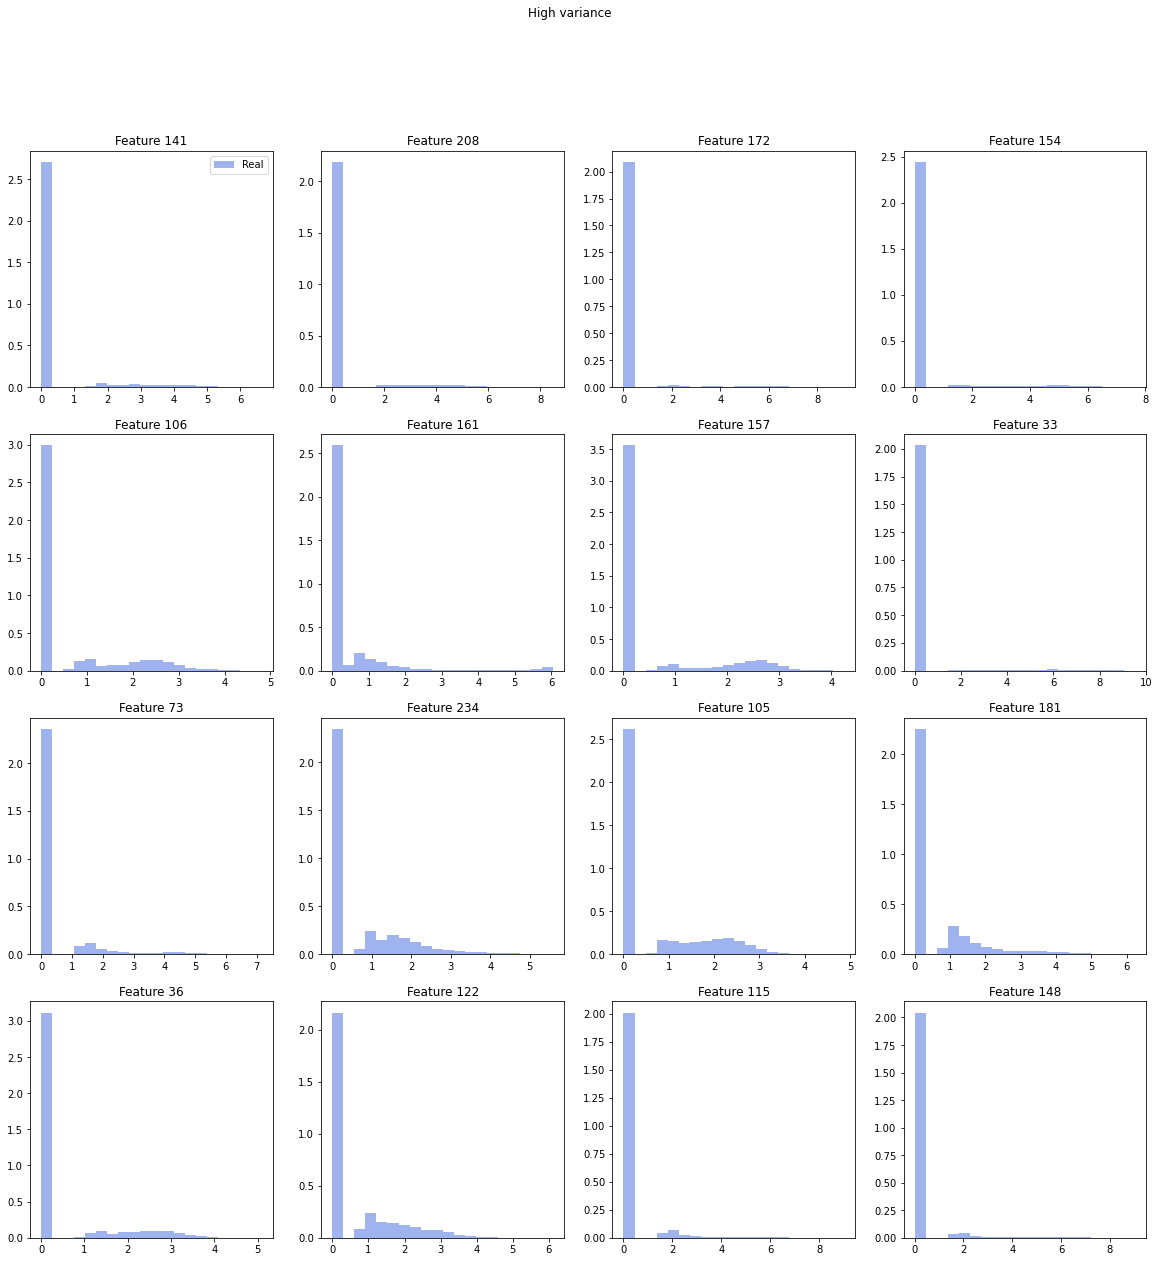

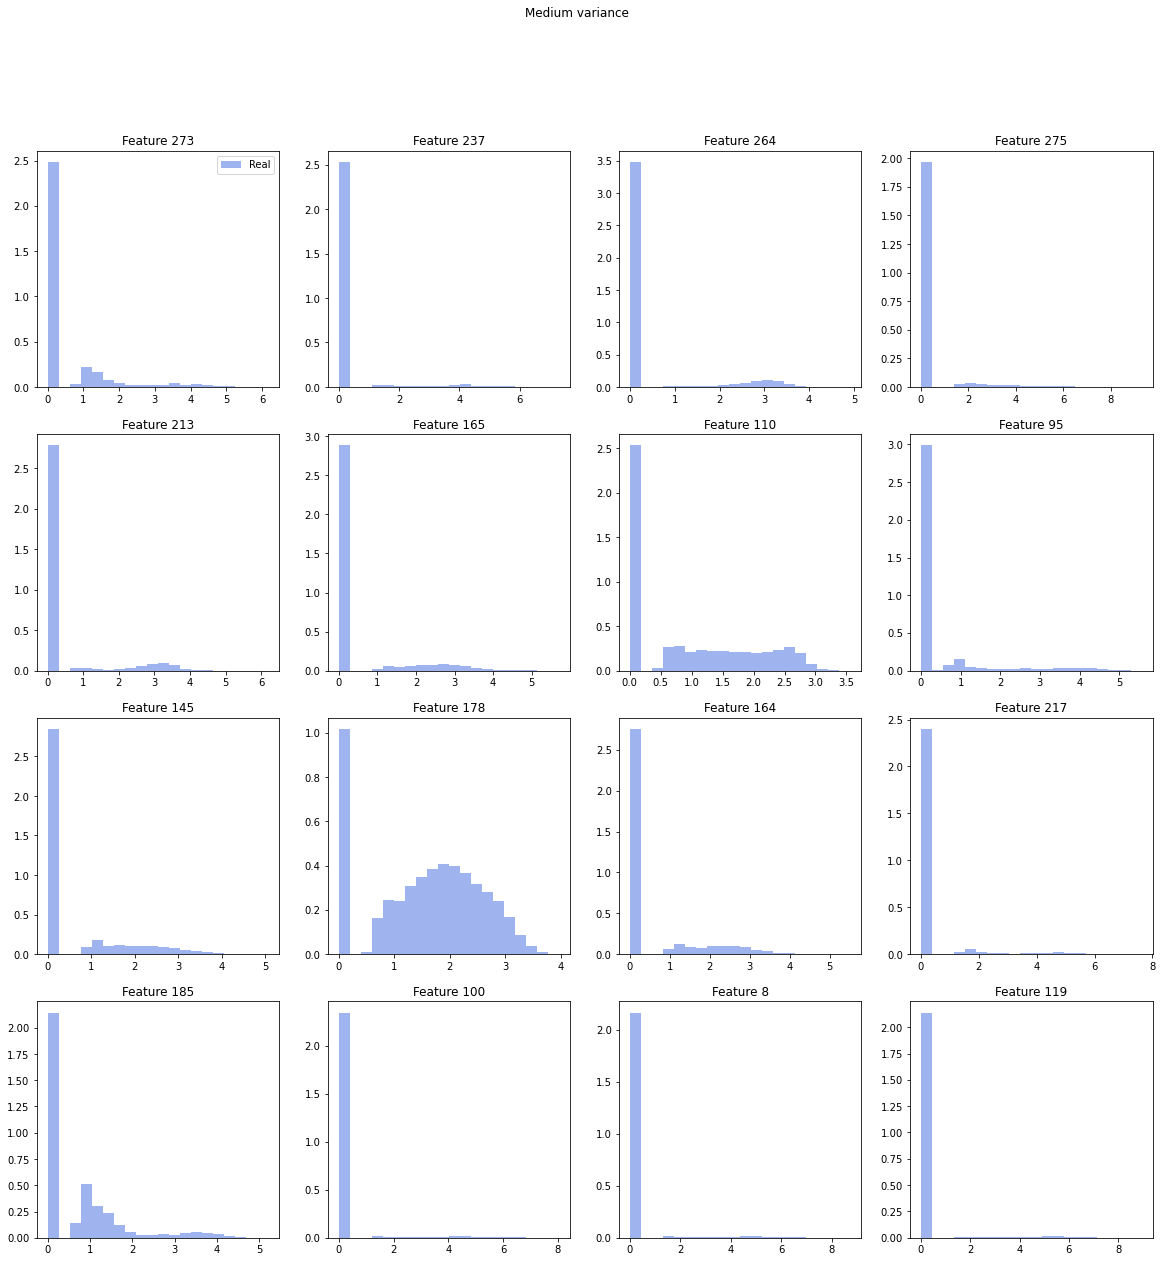

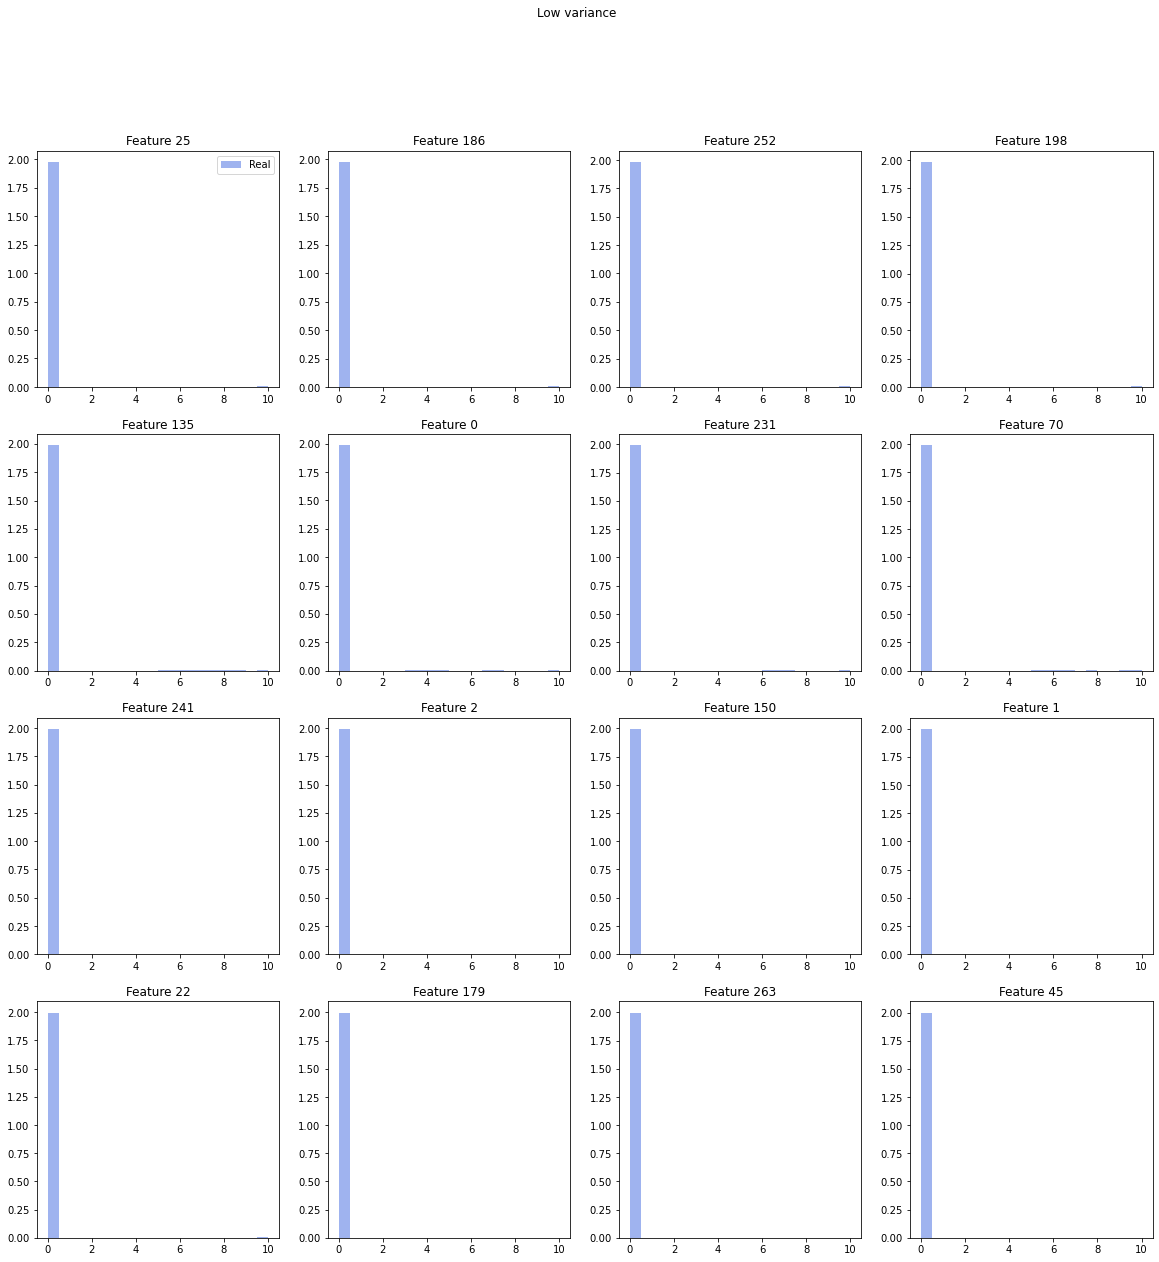

In [5]:
# Plot features
x = dataset.data
inds = np.flip(np.argsort(np.std(x, axis=0)))
num_features = 16
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20

for name, feature_inds in [
    ("High variance", inds[:num_features]),
    ("Medium variance", inds[(len(inds) // 2) - (num_features // 2):(len(inds) // 2) - (num_features // 2) + num_features]),
    ("Low variance", inds[-num_features:])
]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        vals = x[:, f_i]
        ax[r][c].hist(vals, bins=num_bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    fig.suptitle(name)
    plt.show()

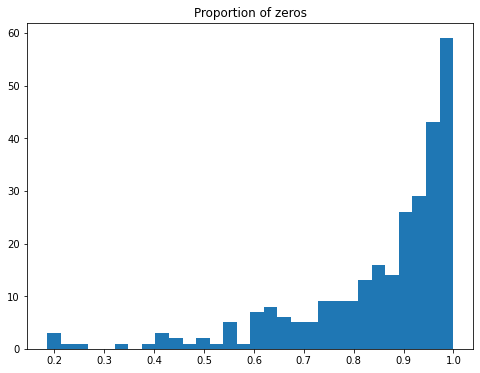

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(np.sum(x == 0, axis=0) / x.shape[0], bins=30)
ax.set_title("Proportion of zeros")
plt.show()

In [7]:
epsilon = 1e-1
feature_weights = torch.tensor(np.maximum(1 - (np.sum(x == 0, axis=0) / x.shape[0]), epsilon)).to(DEVICE)

In [8]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [9]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)

t_limit = 1

model = scrna_ae.MultitaskResNet(
    len(branch_defs), input_shape[0], t_limit=t_limit, hidden_dim=4096
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/misc"
os.environ["MODEL_DIR"] = "/gstore/scratch/u/tsenga5/branched_diffusion/models/trained_models/misc"
import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

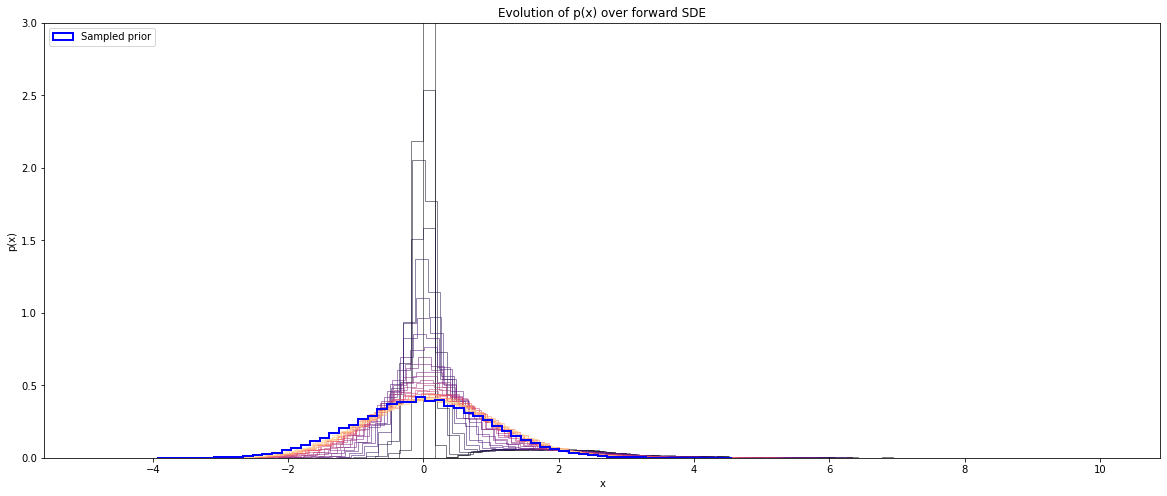

In [10]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [ ]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 300,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm",
        "feature_weights": feature_weights
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "feature_weights"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "63"
Loss: 21.48: 100%|██████████████████████████████████████████| 290/290 [00:13<00:00, 21.94it/s]


Epoch 1 average Loss: 31.79


Loss: 22.60: 100%|██████████████████████████████████████████| 290/290 [00:25<00:00, 11.40it/s]


Epoch 2 average Loss: 22.60


Loss: 22.28: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.62it/s]


Epoch 3 average Loss: 21.20


Loss: 21.25: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.38it/s]


Epoch 4 average Loss: 20.59


Loss: 18.34: 100%|██████████████████████████████████████████| 290/290 [00:54<00:00,  5.34it/s]


Epoch 5 average Loss: 19.68


Loss: 18.56: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.40it/s]


Epoch 6 average Loss: 19.34


Loss: 17.69: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.54it/s]


Epoch 7 average Loss: 19.01


Loss: 18.81: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.45it/s]


Epoch 8 average Loss: 18.62


Loss: 17.29: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.50it/s]


Epoch 9 average Loss: 18.22


Loss: 18.02: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.50it/s]


Epoch 10 average Loss: 17.83


Loss: 17.47: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.55it/s]


Epoch 11 average Loss: 17.70


Loss: 16.96: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.39it/s]


Epoch 12 average Loss: 17.49


Loss: 16.87: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.48it/s]


Epoch 13 average Loss: 17.27


Loss: 17.05: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.64it/s]


Epoch 14 average Loss: 16.99


Loss: 18.73: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.63it/s]


Epoch 15 average Loss: 16.83


Loss: 15.56: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.48it/s]


Epoch 16 average Loss: 16.52


Loss: 15.81: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.44it/s]


Epoch 17 average Loss: 16.44


Loss: 16.90: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.44it/s]


Epoch 18 average Loss: 16.29


Loss: 16.57: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.50it/s]


Epoch 19 average Loss: 16.08


Loss: 15.84: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.39it/s]


Epoch 20 average Loss: 15.87


Loss: 17.57: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.66it/s]


Epoch 21 average Loss: 15.84


Loss: 15.00: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.54it/s]


Epoch 22 average Loss: 15.56


Loss: 15.61: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.43it/s]


Epoch 23 average Loss: 15.40


Loss: 15.02: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.54it/s]


Epoch 24 average Loss: 15.37


Loss: 16.89: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.44it/s]


Epoch 25 average Loss: 15.26


Loss: 14.38: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.42it/s]


Epoch 26 average Loss: 15.15


Loss: 14.97: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.57it/s]


Epoch 27 average Loss: 15.07


Loss: 15.39: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.60it/s]


Epoch 28 average Loss: 14.95


Loss: 16.41: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.48it/s]


Epoch 29 average Loss: 14.76


Loss: 14.71: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.48it/s]


Epoch 30 average Loss: 14.78


Loss: 15.28: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.38it/s]


Epoch 31 average Loss: 14.81


Loss: 14.62: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.60it/s]


Epoch 32 average Loss: 14.61


Loss: 13.49: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.56it/s]


Epoch 33 average Loss: 14.48


Loss: 15.59: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.56it/s]


Epoch 34 average Loss: 14.52


Loss: 14.45: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.54it/s]


Epoch 35 average Loss: 14.42


Loss: 13.89: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.58it/s]


Epoch 36 average Loss: 14.35


Loss: 14.84: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.51it/s]


Epoch 37 average Loss: 14.17


Loss: 14.23: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.53it/s]


Epoch 38 average Loss: 14.22


Loss: 14.34: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.59it/s]


Epoch 39 average Loss: 14.12


Loss: 14.50: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.63it/s]


Epoch 40 average Loss: 14.03


Loss: 12.15: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.44it/s]


Epoch 41 average Loss: 13.94


Loss: 15.05: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.66it/s]


Epoch 42 average Loss: 13.96


Loss: 13.97: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.52it/s]


Epoch 43 average Loss: 14.00


Loss: 14.15: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.61it/s]


Epoch 44 average Loss: 13.85


Loss: 13.40: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.50it/s]


Epoch 45 average Loss: 13.80


Loss: 14.33: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.68it/s]


Epoch 46 average Loss: 13.71


Loss: 13.76: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.61it/s]


Epoch 47 average Loss: 13.62


Loss: 13.35: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.47it/s]


Epoch 48 average Loss: 13.57


Loss: 12.72: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.59it/s]


Epoch 49 average Loss: 13.61


Loss: 13.40: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.59it/s]


Epoch 50 average Loss: 13.57


Loss: 12.36: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.63it/s]


Epoch 51 average Loss: 13.56


Loss: 13.75: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.62it/s]


Epoch 52 average Loss: 13.47


Loss: 13.03: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.61it/s]


Epoch 53 average Loss: 13.41


Loss: 13.75: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.48it/s]


Epoch 54 average Loss: 13.48


Loss: 14.32: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.55it/s]


Epoch 55 average Loss: 13.39


Loss: 13.46: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.56it/s]


Epoch 56 average Loss: 13.38


Loss: 12.65: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.67it/s]


Epoch 57 average Loss: 13.32


Loss: 13.16: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.55it/s]


Epoch 58 average Loss: 13.25


Loss: 15.00: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.47it/s]


Epoch 59 average Loss: 13.25


Loss: 12.75: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.58it/s]


Epoch 60 average Loss: 13.19


Loss: 12.89: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.61it/s]


Epoch 61 average Loss: 13.15


Loss: 14.46: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.49it/s]


Epoch 62 average Loss: 13.24


Loss: 12.92: 100%|██████████████████████████████████████████| 290/290 [00:53<00:00,  5.44it/s]


Epoch 63 average Loss: 13.16


Loss: 12.35: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.58it/s]


Epoch 64 average Loss: 13.07


Loss: 12.90: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.57it/s]


Epoch 65 average Loss: 13.08


Loss: 12.07: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.63it/s]


Epoch 66 average Loss: 13.12


Loss: 12.08: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.56it/s]


Epoch 67 average Loss: 13.04


Loss: 12.29: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.61it/s]


Epoch 68 average Loss: 13.09


Loss: 12.28: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.51it/s]


Epoch 69 average Loss: 13.02


Loss: 13.54: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.60it/s]


Epoch 70 average Loss: 13.01


Loss: 11.38: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.50it/s]


Epoch 71 average Loss: 12.94


Loss: 12.67: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.64it/s]


Epoch 72 average Loss: 12.99


Loss: 12.57: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.67it/s]


Epoch 73 average Loss: 12.86


Loss: 12.98: 100%|██████████████████████████████████████████| 290/290 [00:50<00:00,  5.72it/s]


Epoch 74 average Loss: 12.79


Loss: 12.43: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.58it/s]


Epoch 75 average Loss: 12.81


Loss: 12.10: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.58it/s]


Epoch 76 average Loss: 12.94


Loss: 13.33: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.59it/s]


Epoch 77 average Loss: 12.82


Loss: 12.62: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.64it/s]


Epoch 78 average Loss: 12.71


Loss: 13.78: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.63it/s]


Epoch 79 average Loss: 12.84


Loss: 12.46: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.68it/s]


Epoch 80 average Loss: 12.68


Loss: 12.58: 100%|██████████████████████████████████████████| 290/290 [00:52<00:00,  5.48it/s]


Epoch 81 average Loss: 12.74


Loss: 13.23: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.65it/s]


Epoch 82 average Loss: 12.68


Loss: 14.57: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.62it/s]


Epoch 83 average Loss: 12.68


Loss: 12.25: 100%|██████████████████████████████████████████| 290/290 [00:50<00:00,  5.76it/s]


Epoch 84 average Loss: 12.61


Loss: 13.42: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.67it/s]


Epoch 85 average Loss: 12.64


Loss: 12.71: 100%|██████████████████████████████████████████| 290/290 [00:50<00:00,  5.71it/s]


Epoch 86 average Loss: 12.63


Loss: 13.81: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.68it/s]


Epoch 87 average Loss: 12.67


Loss: 12.49: 100%|██████████████████████████████████████████| 290/290 [00:50<00:00,  5.69it/s]


Epoch 88 average Loss: 12.50


Loss: 13.08: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.67it/s]


Epoch 89 average Loss: 12.52


Loss: 12.08: 100%|██████████████████████████████████████████| 290/290 [00:50<00:00,  5.70it/s]


Epoch 90 average Loss: 12.57


Loss: 12.89: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.67it/s]


Epoch 91 average Loss: 12.48


Loss: 13.13: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.67it/s]


Epoch 94 average Loss: 12.53


Loss: 12.47: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.69it/s]


Epoch 95 average Loss: 12.32


Loss: 13.49: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.67it/s]


Epoch 96 average Loss: 12.46


Loss: 11.58: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.58it/s]


Epoch 97 average Loss: 12.47


Loss: 12.91: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.67it/s]


Epoch 98 average Loss: 12.44


Loss: 11.23: 100%|██████████████████████████████████████████| 290/290 [00:51<00:00,  5.66it/s]


Epoch 99 average Loss: 12.38


Loss: 11.13:  26%|██████████▉                                | 74/290 [00:13<00:33,  6.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 11.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:51<00:00,  5.62it/s]


Epoch 124 average Loss: 12.08


Loss: 11.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.80it/s]


Epoch 125 average Loss: 12.01


Loss: 12.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:51<00:00,  5.62it/s]


Epoch 126 average Loss: 11.96


Loss: 11.63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:51<00:00,  5.64it/s]


Epoch 127 average Loss: 12.06


Loss: 11.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:51<00:00,  5.62it/s]


Epoch 128 average Loss: 12.03


Loss: 12.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.80it/s]


Epoch 129 average Loss: 11.96


Loss: 10.96:  28%|██████████████████████████████▌                                                                             | 82/290 [00:15<00:39,  5.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 12.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.82it/s]


Epoch 152 average Loss: 11.73


Loss: 12.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.86it/s]


Epoch 153 average Loss: 11.65


Loss: 13.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:51<00:00,  5.65it/s]


Epoch 154 average Loss: 11.69


Loss: 10.76:  57%|████████████████████████████████████████████████████████████▉                                              | 165/290 [00:29<00:13,  9.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 11.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.70it/s]


Epoch 157 average Loss: 11.78


Loss: 11.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:52<00:00,  5.57it/s]


Epoch 158 average Loss: 11.64


Loss: 12.25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:51<00:00,  5.59it/s]


Epoch 159 average Loss: 11.63


Loss: 12.48:   9%|█████████▋                                                                                                  | 26/290 [00:04<00:51,  5.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 10.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.71it/s]


Epoch 182 average Loss: 11.44


Loss: 12.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.71it/s]


Epoch 183 average Loss: 11.55


Loss: 10.86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.81it/s]


Epoch 184 average Loss: 11.45


Loss: 10.59:  40%|██████████████████████████████████████████▊                                                                | 116/290 [00:20<00:33,  5.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 12.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.70it/s]


Epoch 187 average Loss: 11.45


Loss: 12.26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.87it/s]


Epoch 188 average Loss: 11.42


Loss: 11.61:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 283/290 [00:48<00:01,  5.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 11.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:51<00:00,  5.68it/s]


Epoch 212 average Loss: 11.21


Loss: 11.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.70it/s]


Epoch 213 average Loss: 11.20


Loss: 11.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.72it/s]


Epoch 214 average Loss: 11.23


Loss: 10.34:   2%|█▉                                                                                                           | 5/290 [00:00<00:39,  7.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 10.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.81it/s]


Epoch 217 average Loss: 11.21


Loss: 10.77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.88it/s]


Epoch 218 average Loss: 11.12


Loss: 10.73:  60%|████████████████████████████████████████████████████████████████▏                                          | 174/290 [00:31<00:26,  4.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 11.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:48<00:00,  5.92it/s]


Epoch 241 average Loss: 11.04


Loss: 10.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.80it/s]


Epoch 242 average Loss: 11.02


Loss: 11.05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.90it/s]


Epoch 243 average Loss: 11.05


Loss: 11.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.80it/s]


Epoch 244 average Loss: 10.99


Loss: 12.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.78it/s]


Epoch 245 average Loss: 11.03


Loss: 10.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:50<00:00,  5.71it/s]


Epoch 246 average Loss: 11.05


Loss: 11.73:   5%|█████▌                                                                                                      | 15/290 [00:02<00:47,  5.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Show generated distributions

In [ ]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

Class 0


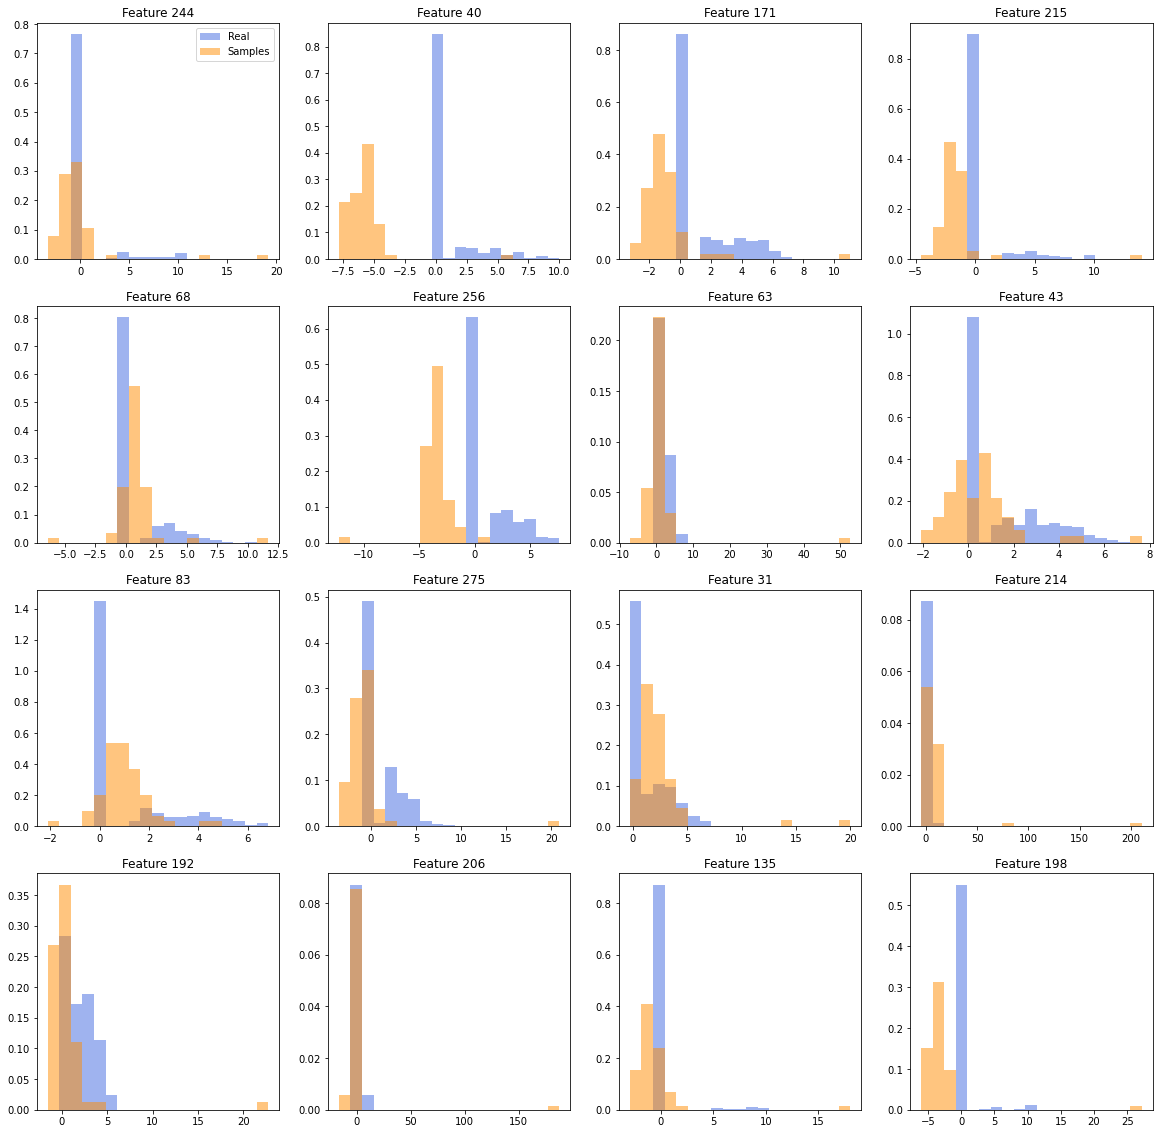

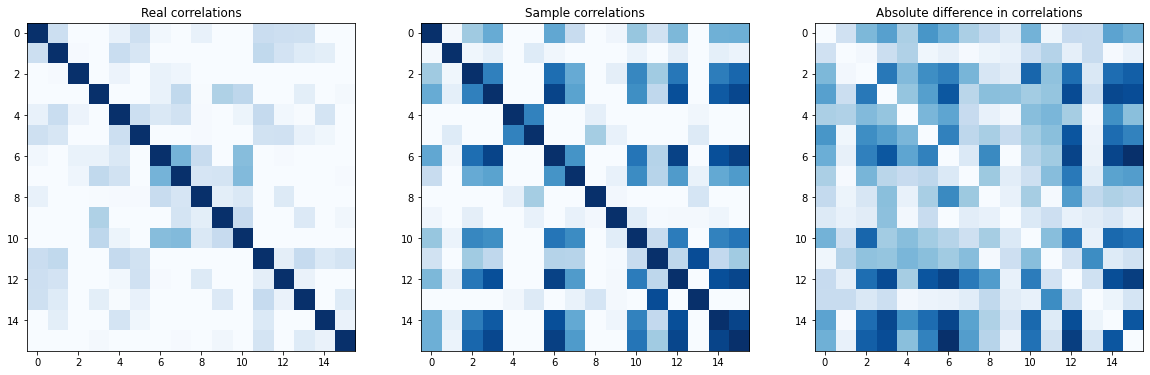

Class 1


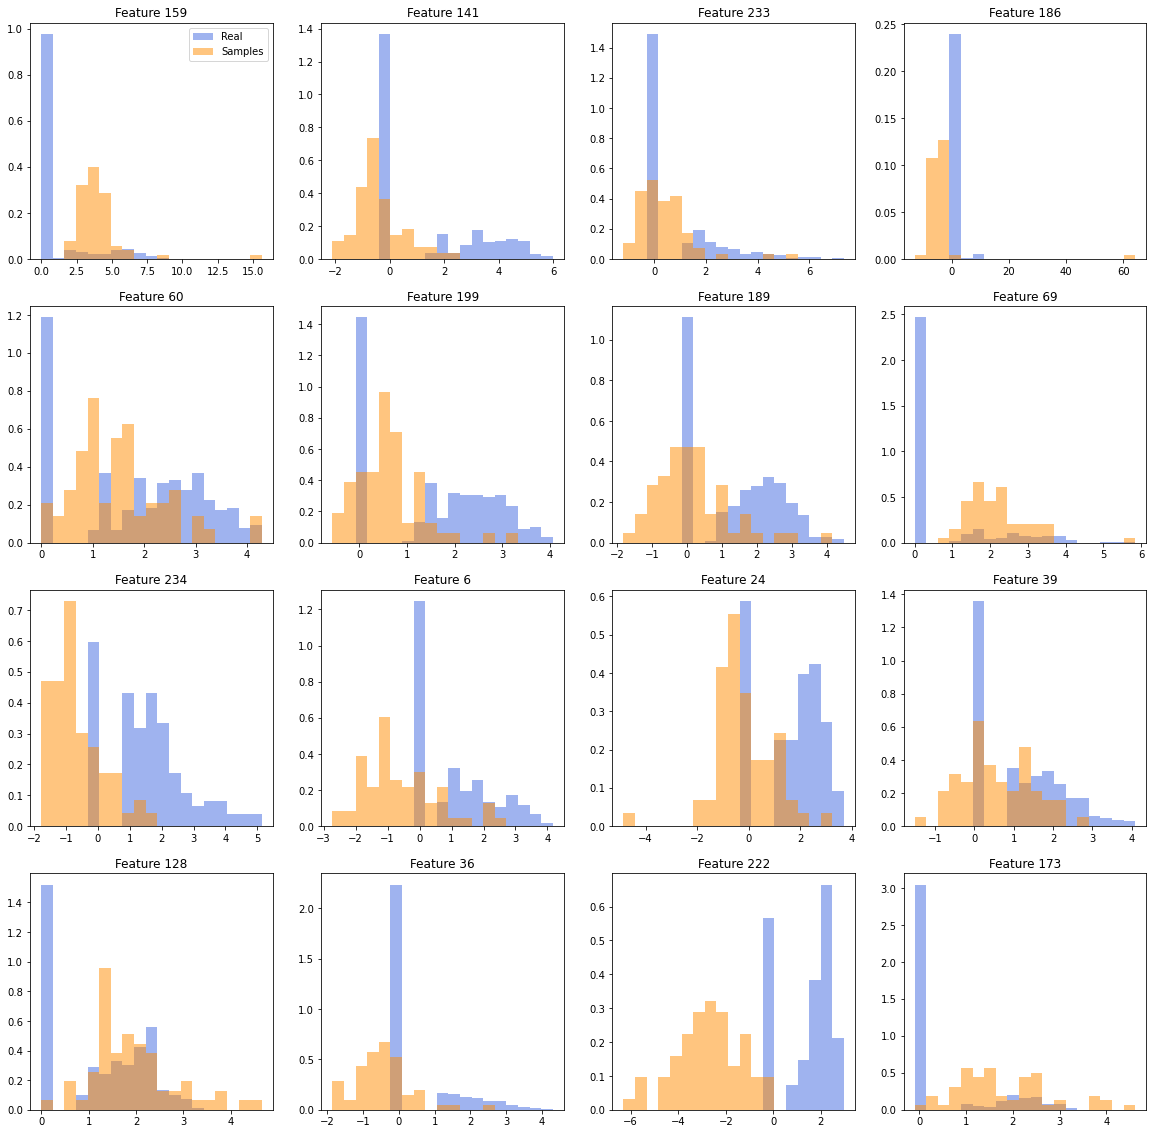

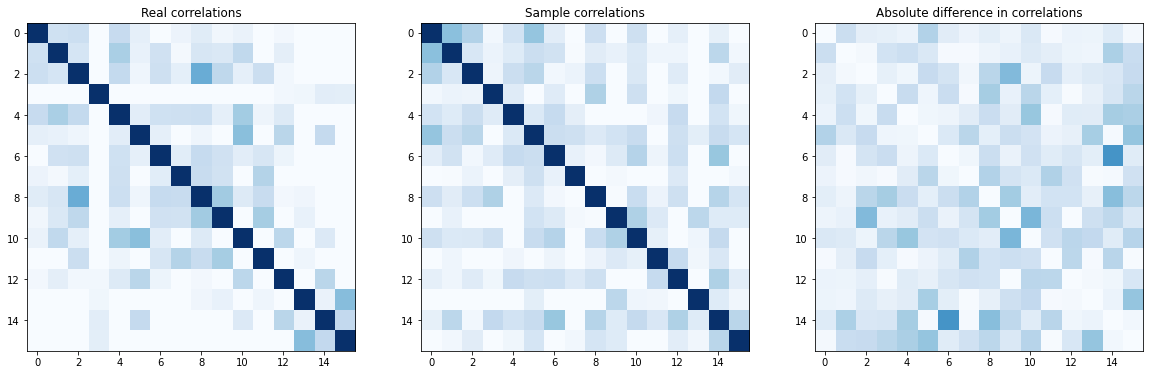

Class 2


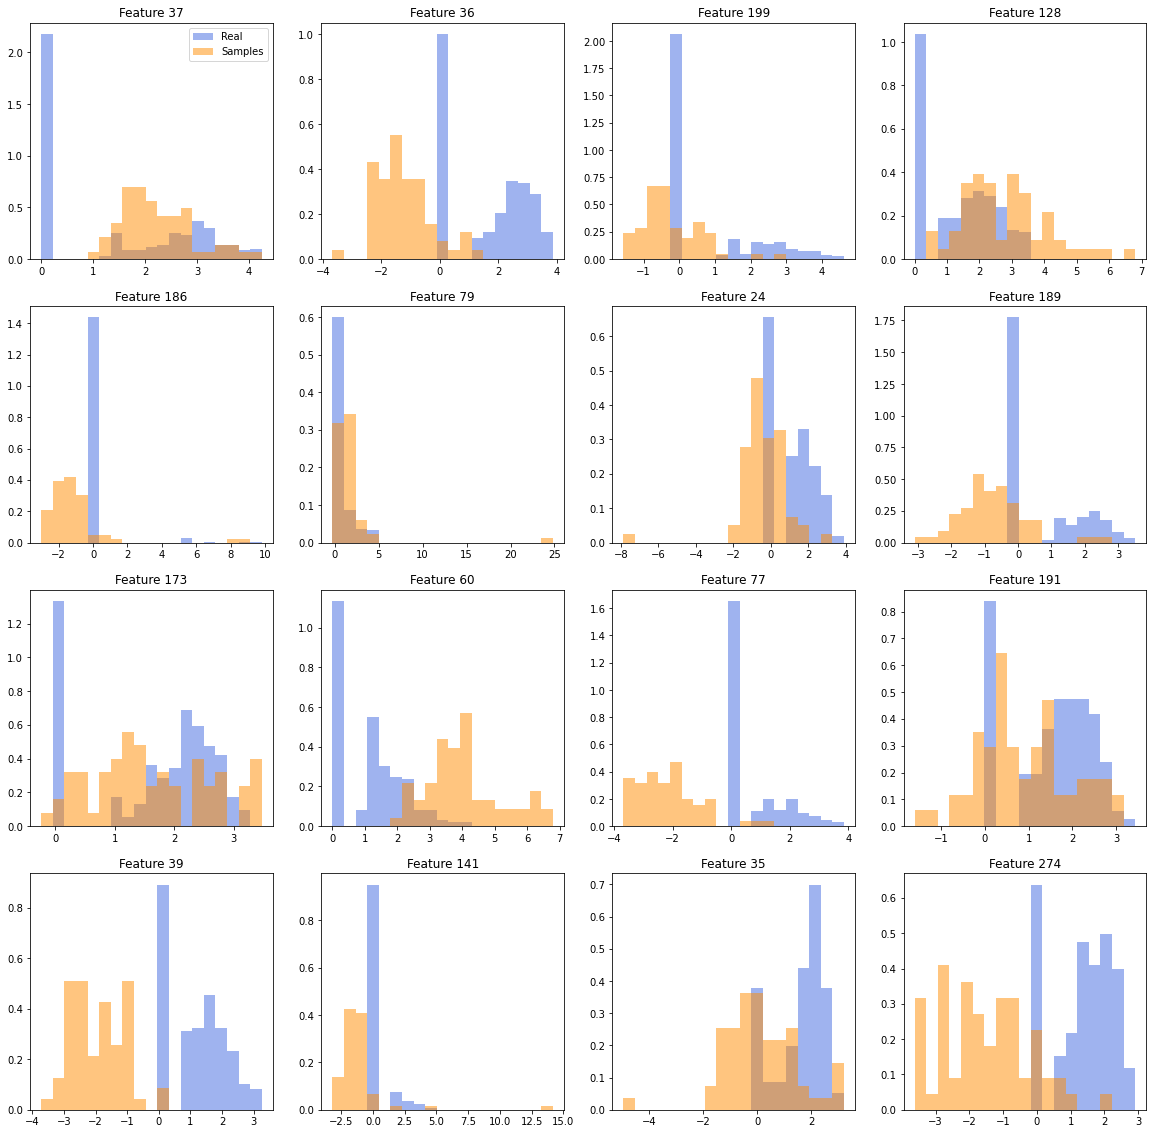

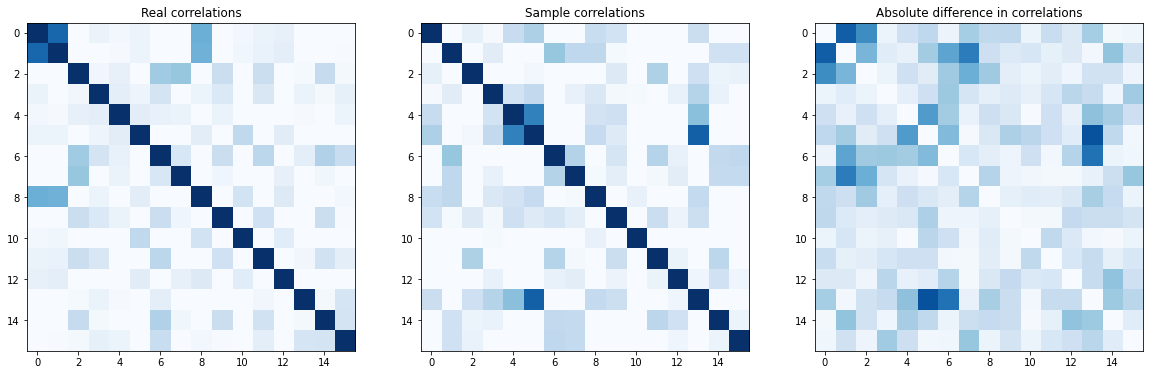

Class 3


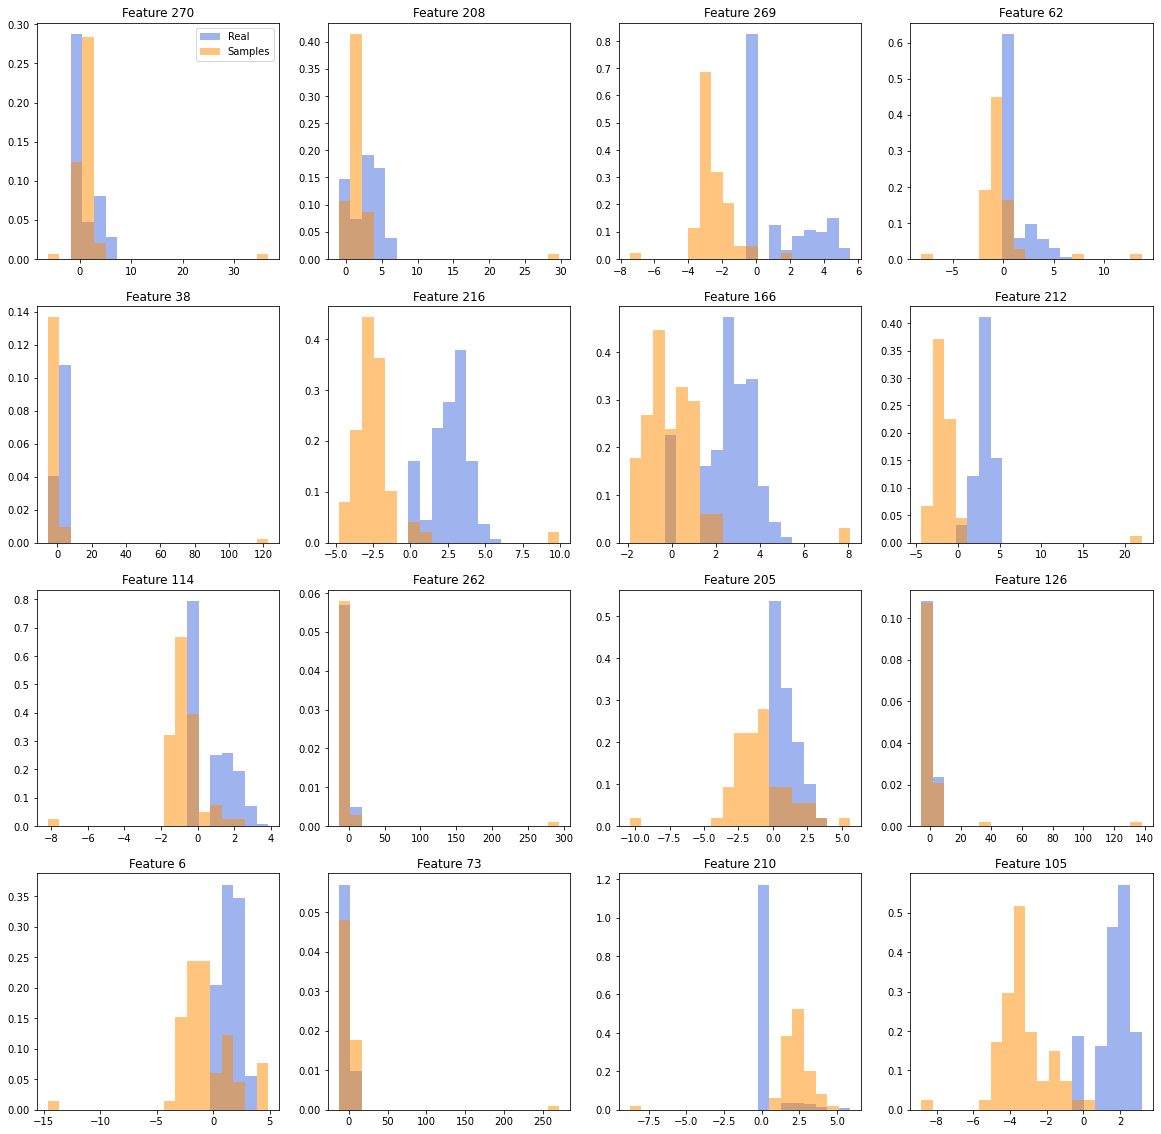

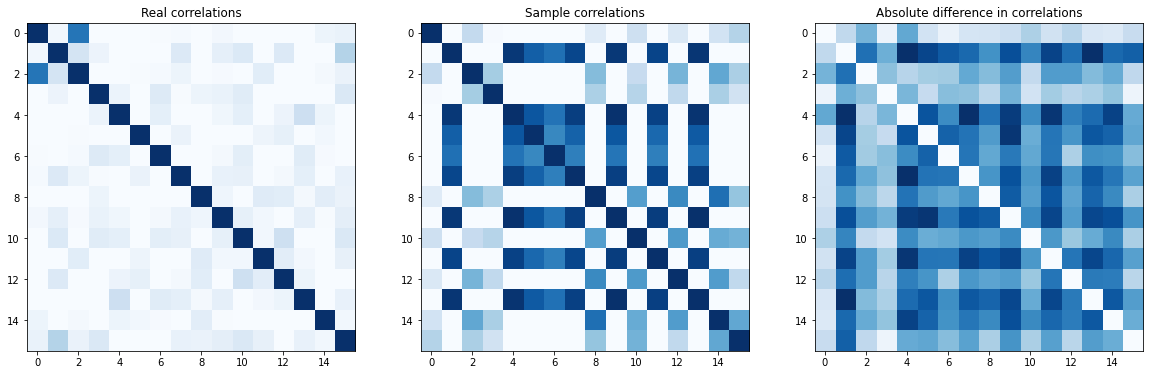

Class 4


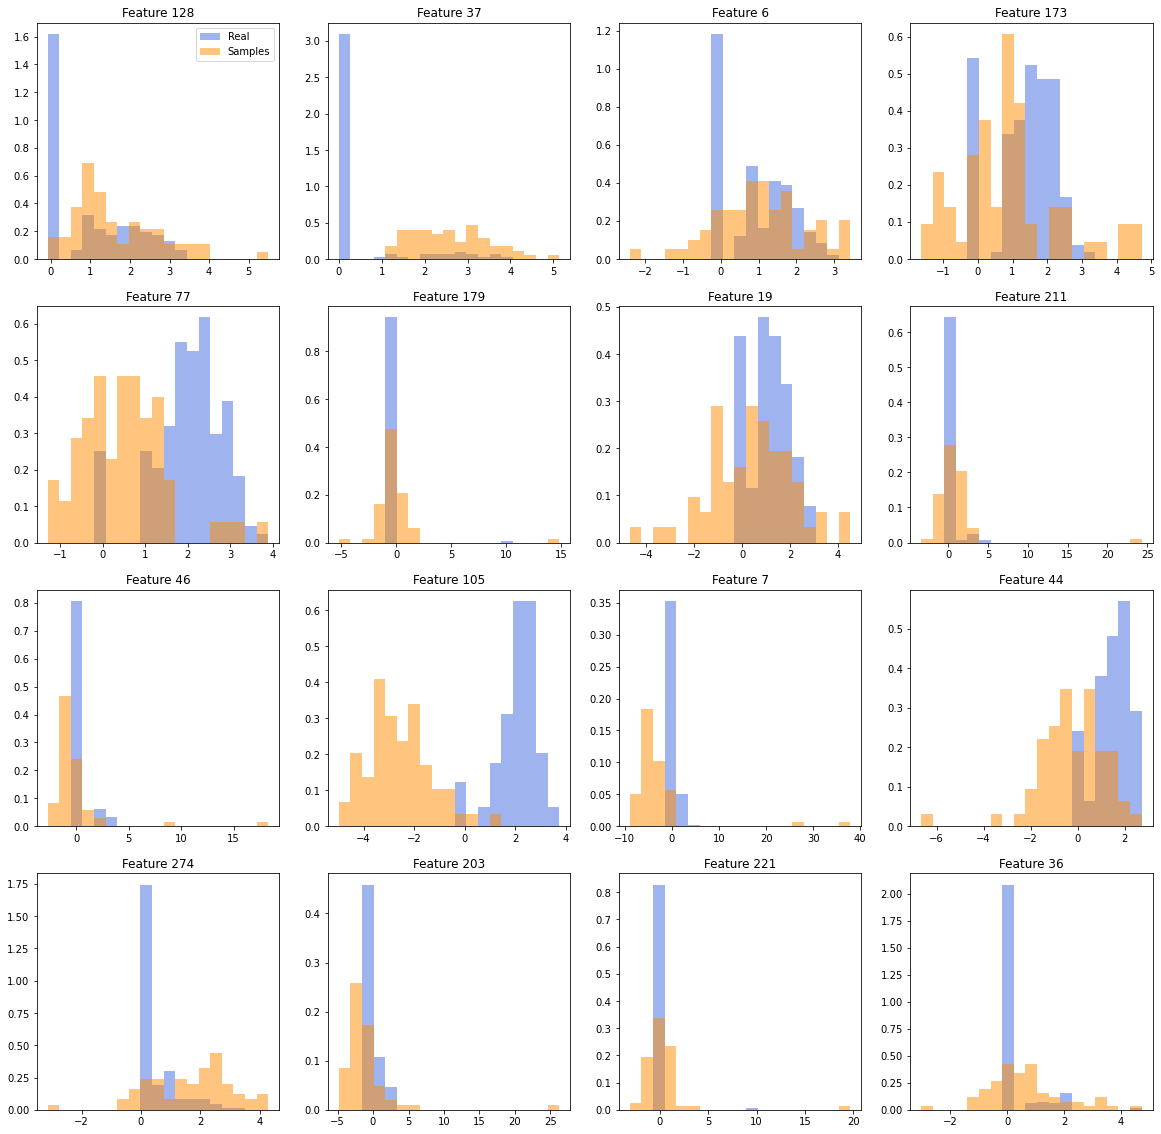

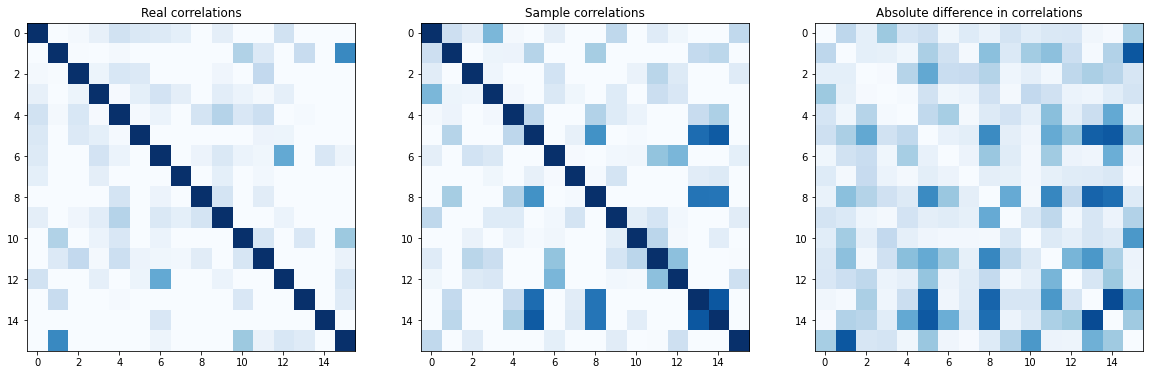

Class 5


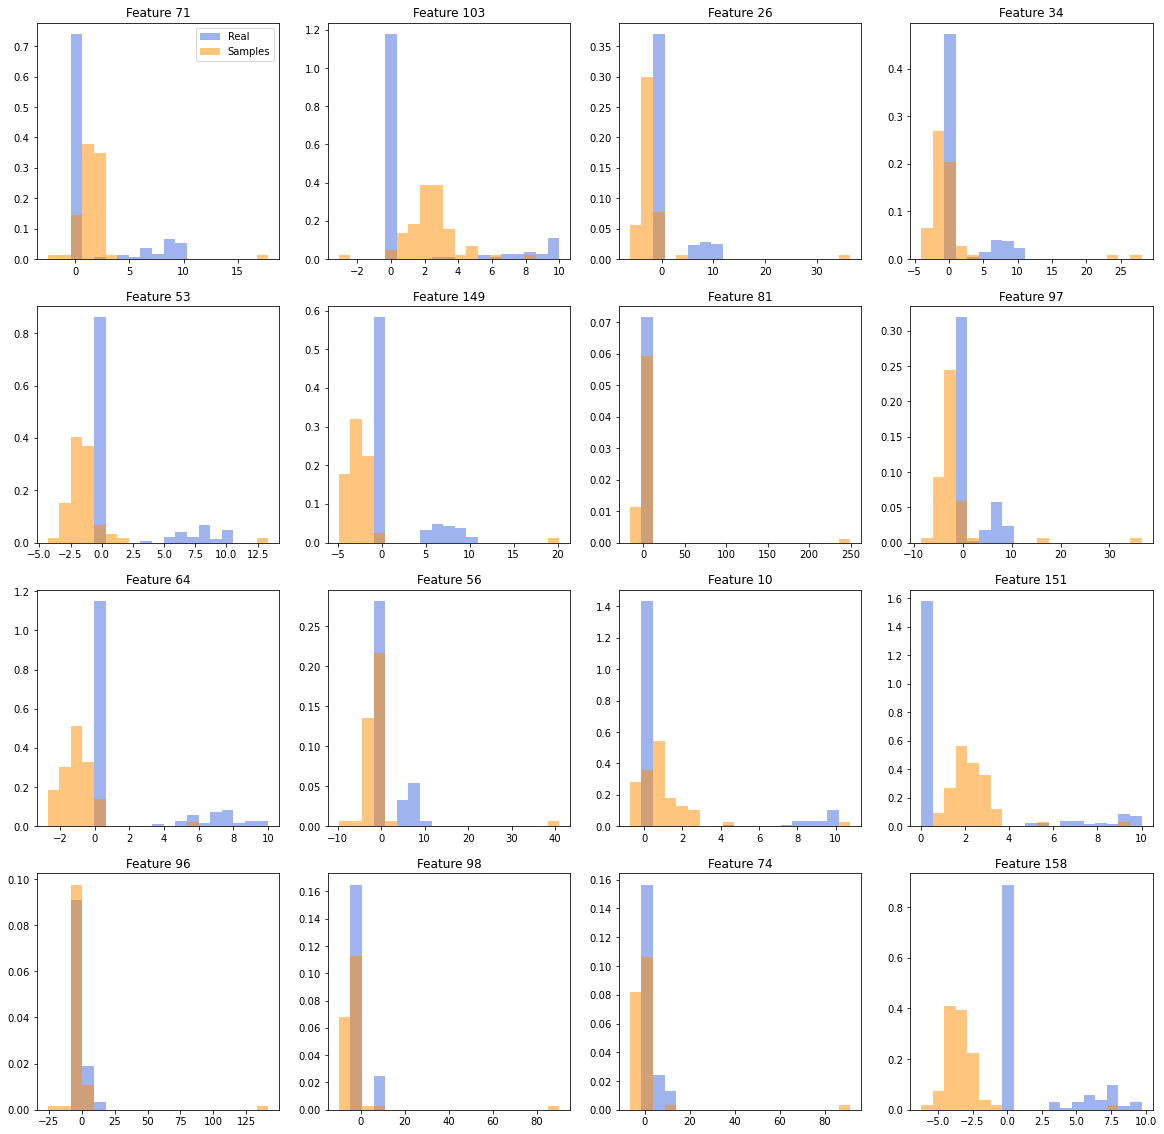

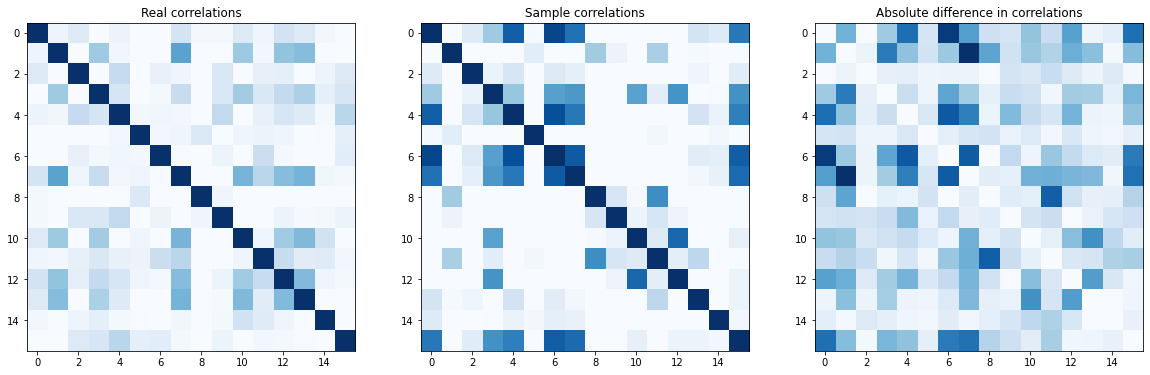

Class 6


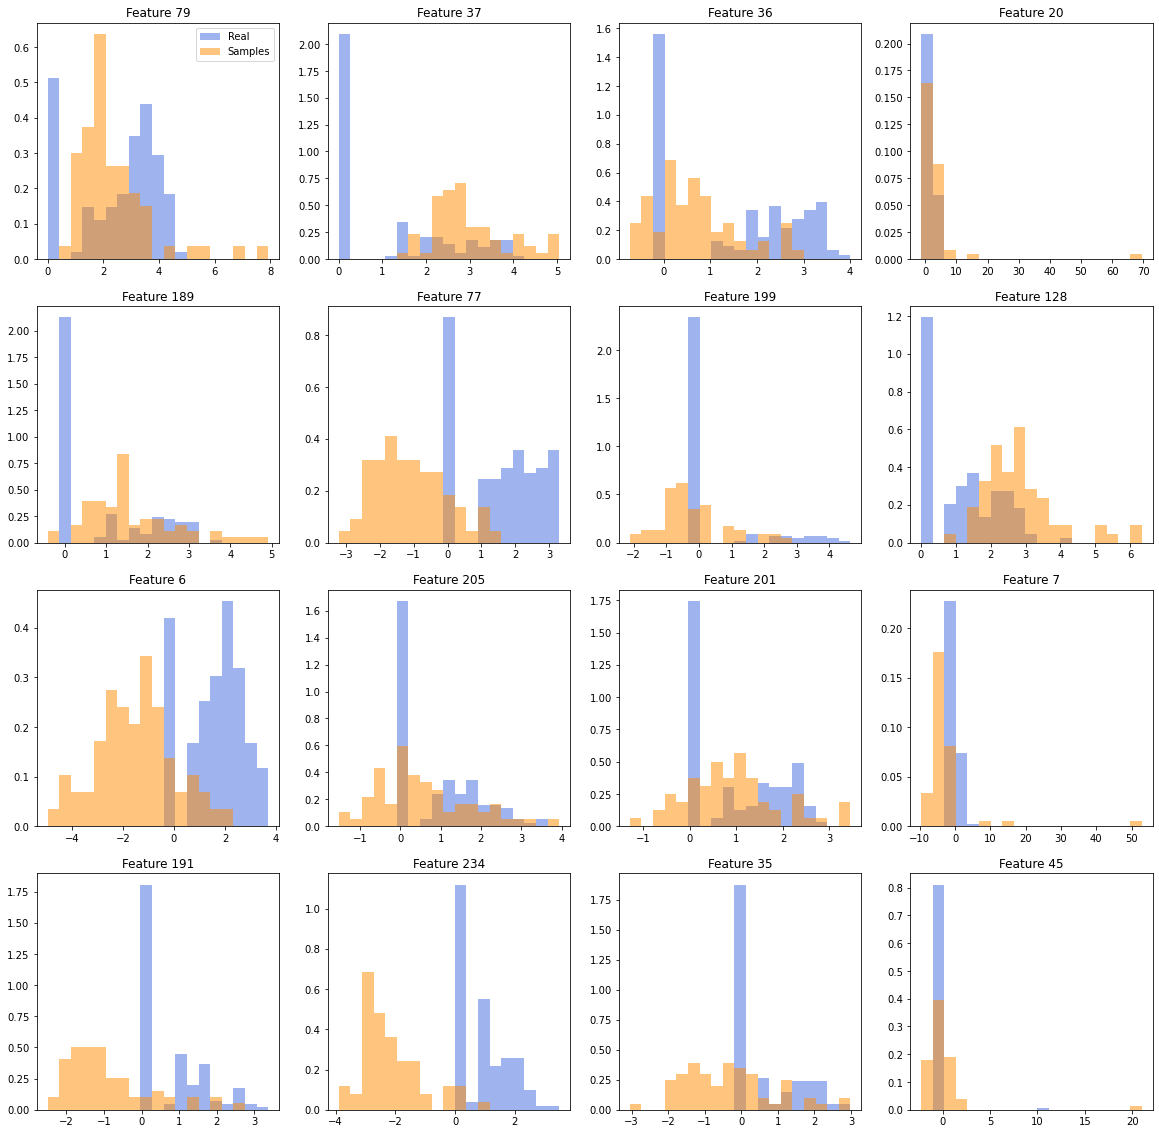

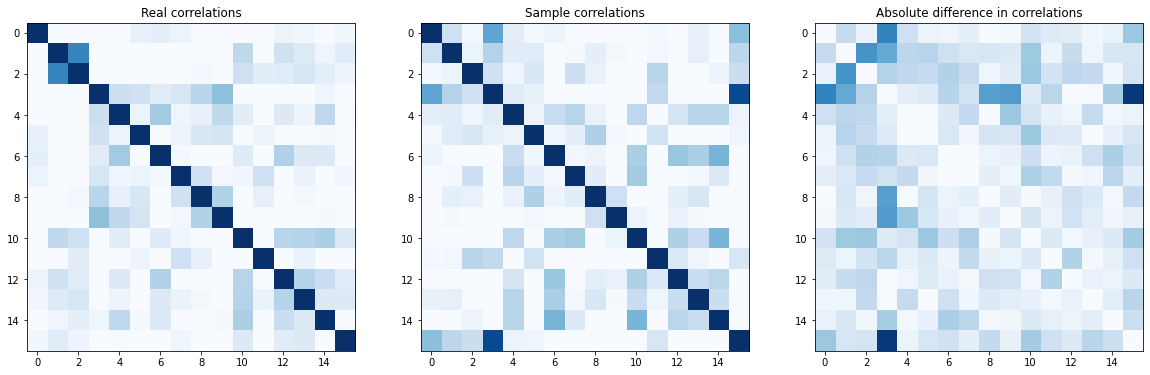

Class 7


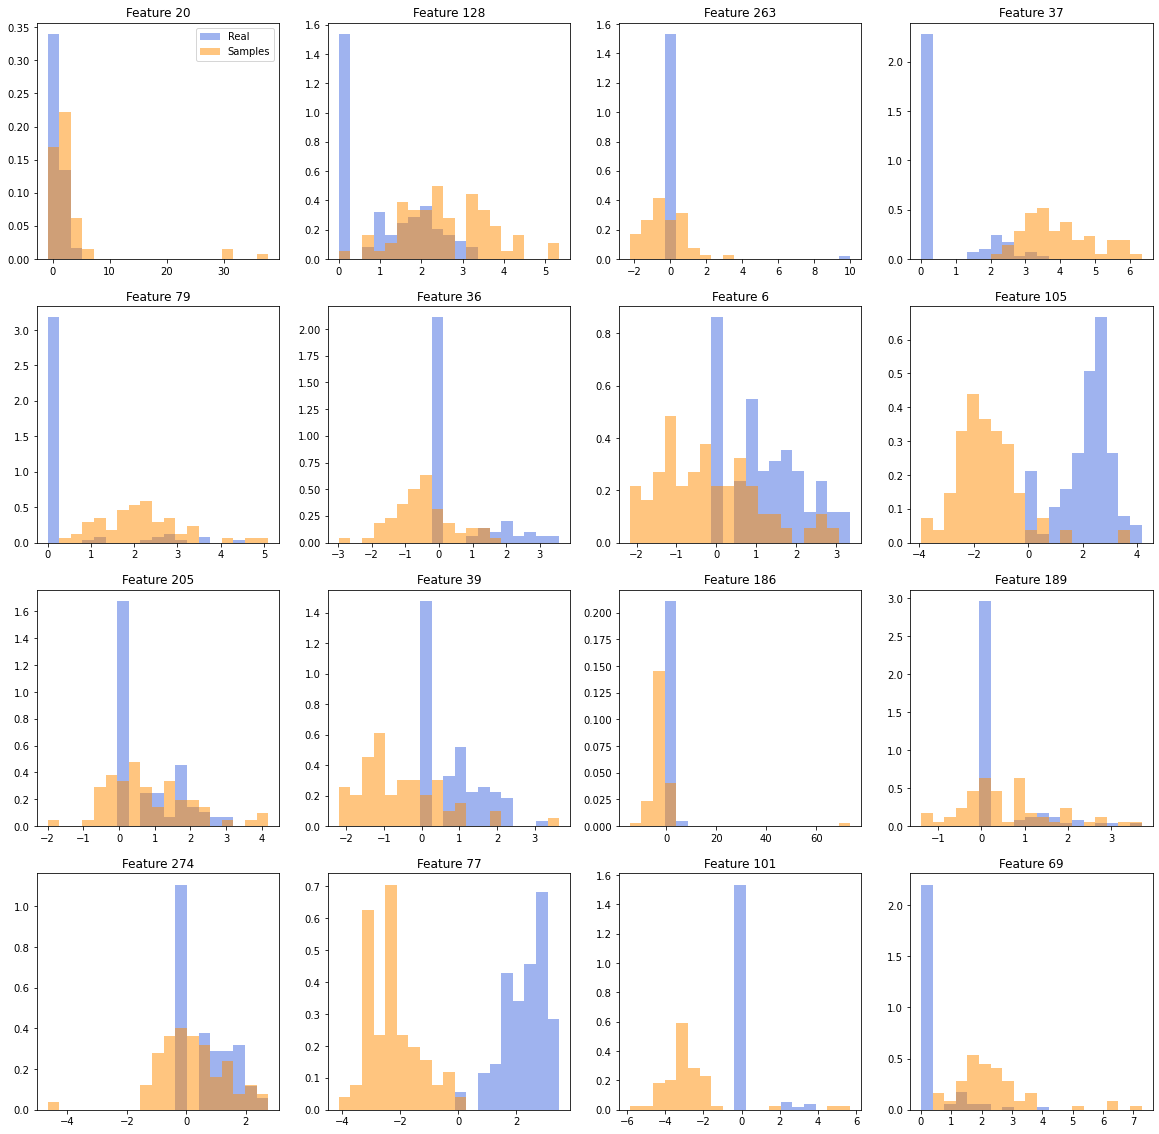

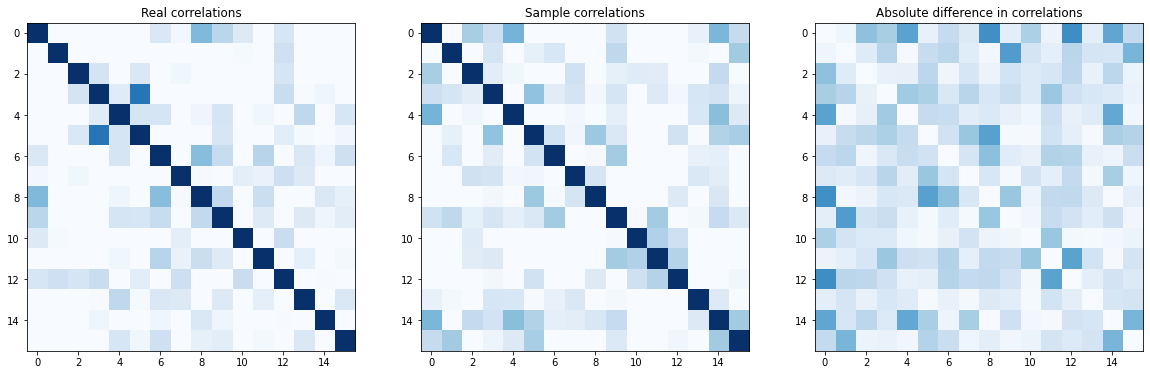

Class 8


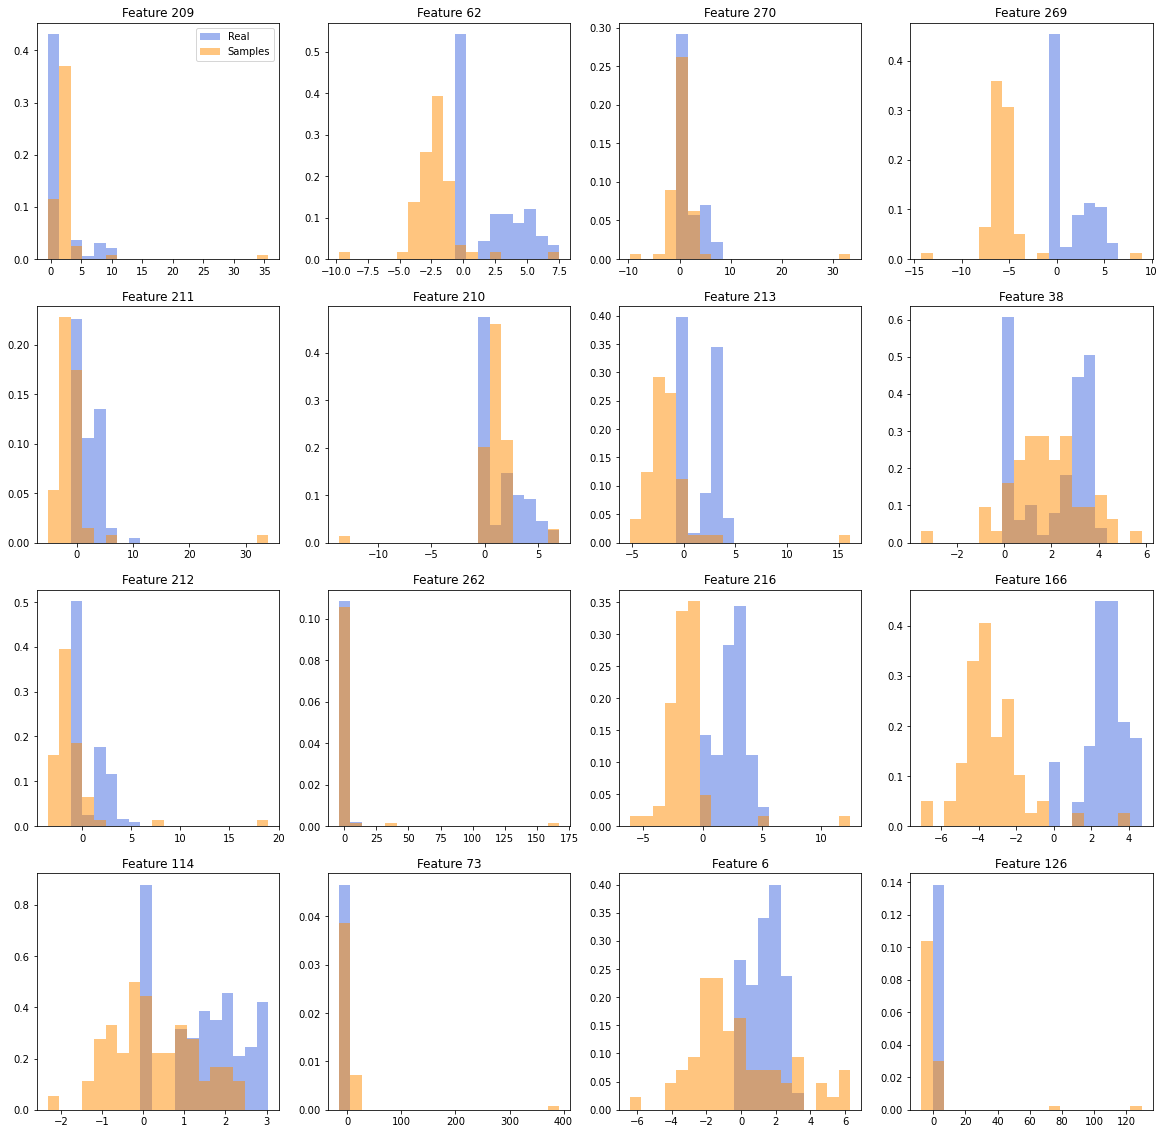

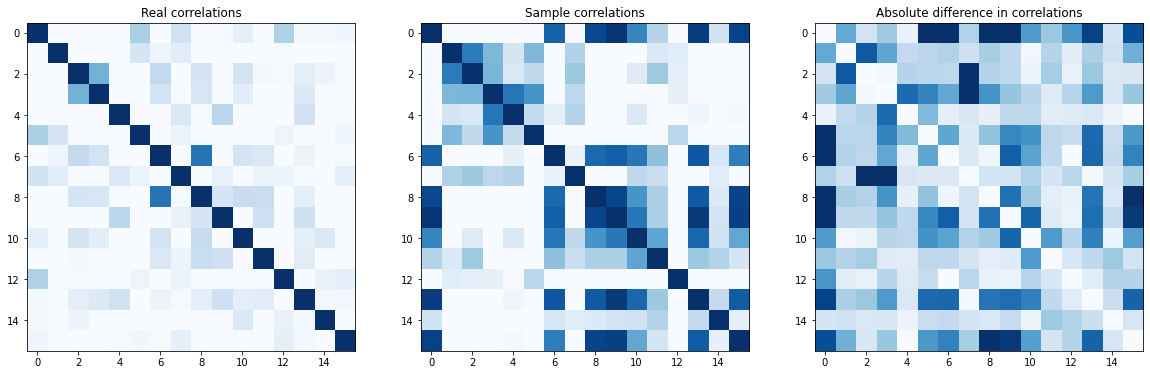

Class 9


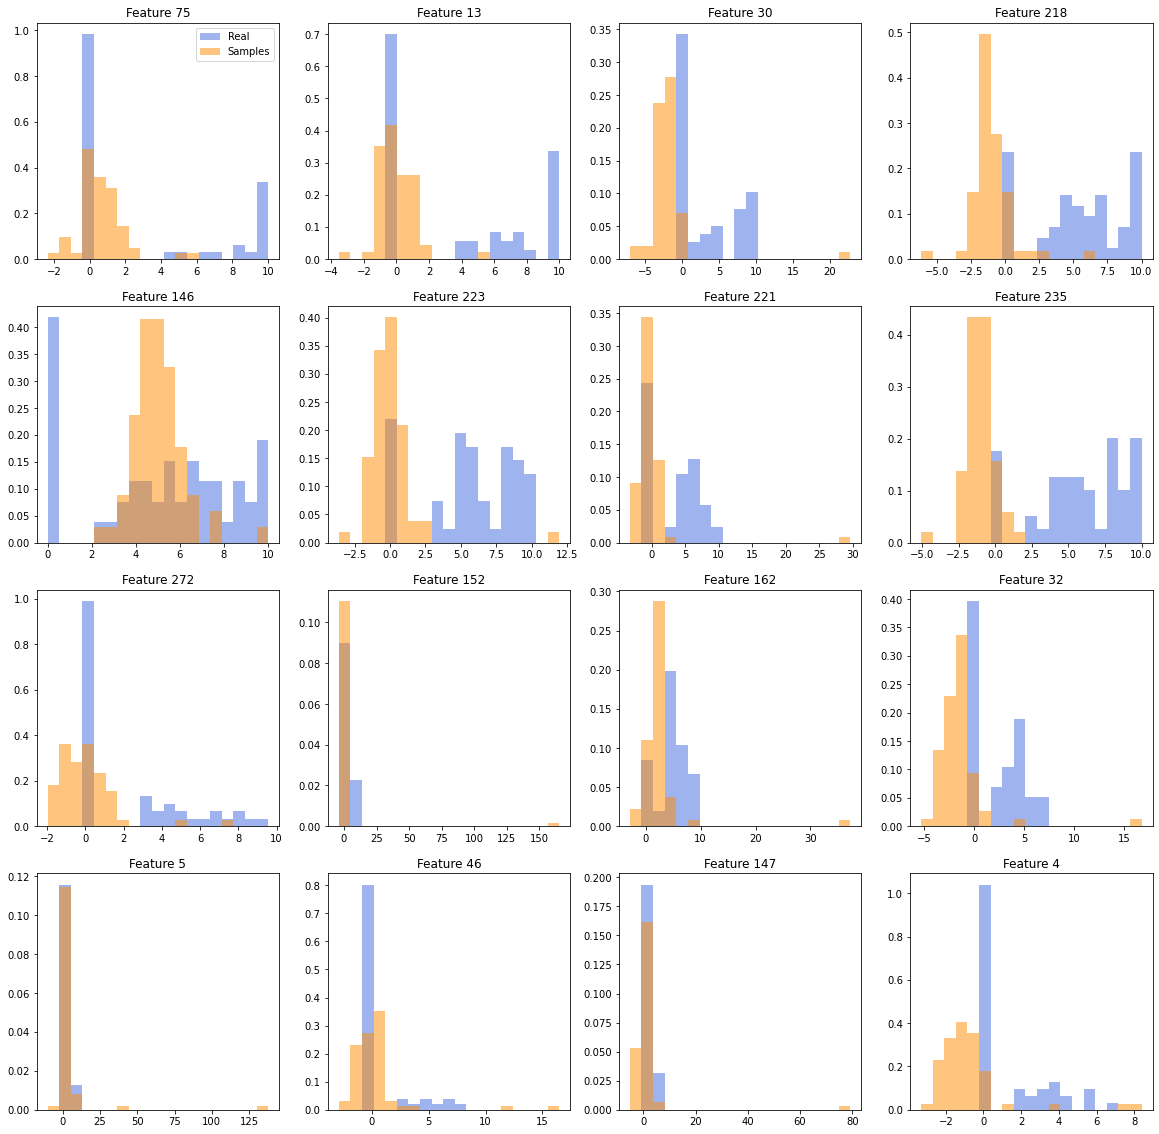

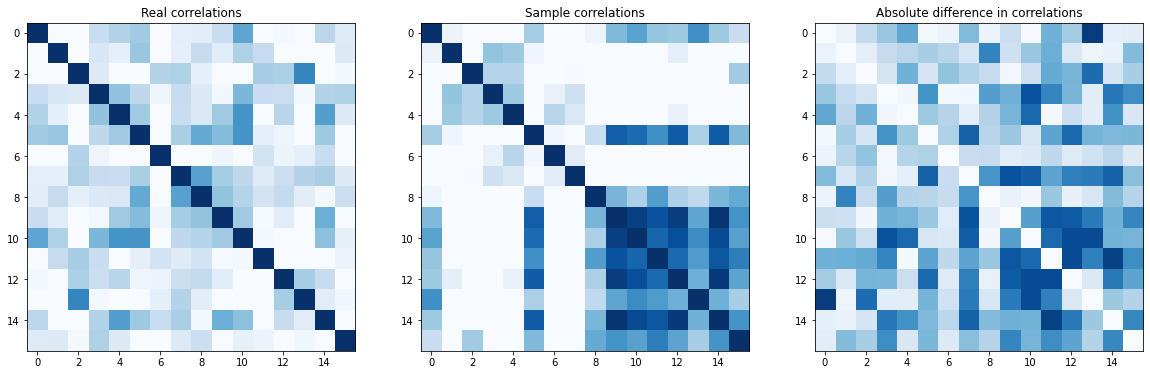

Class 10


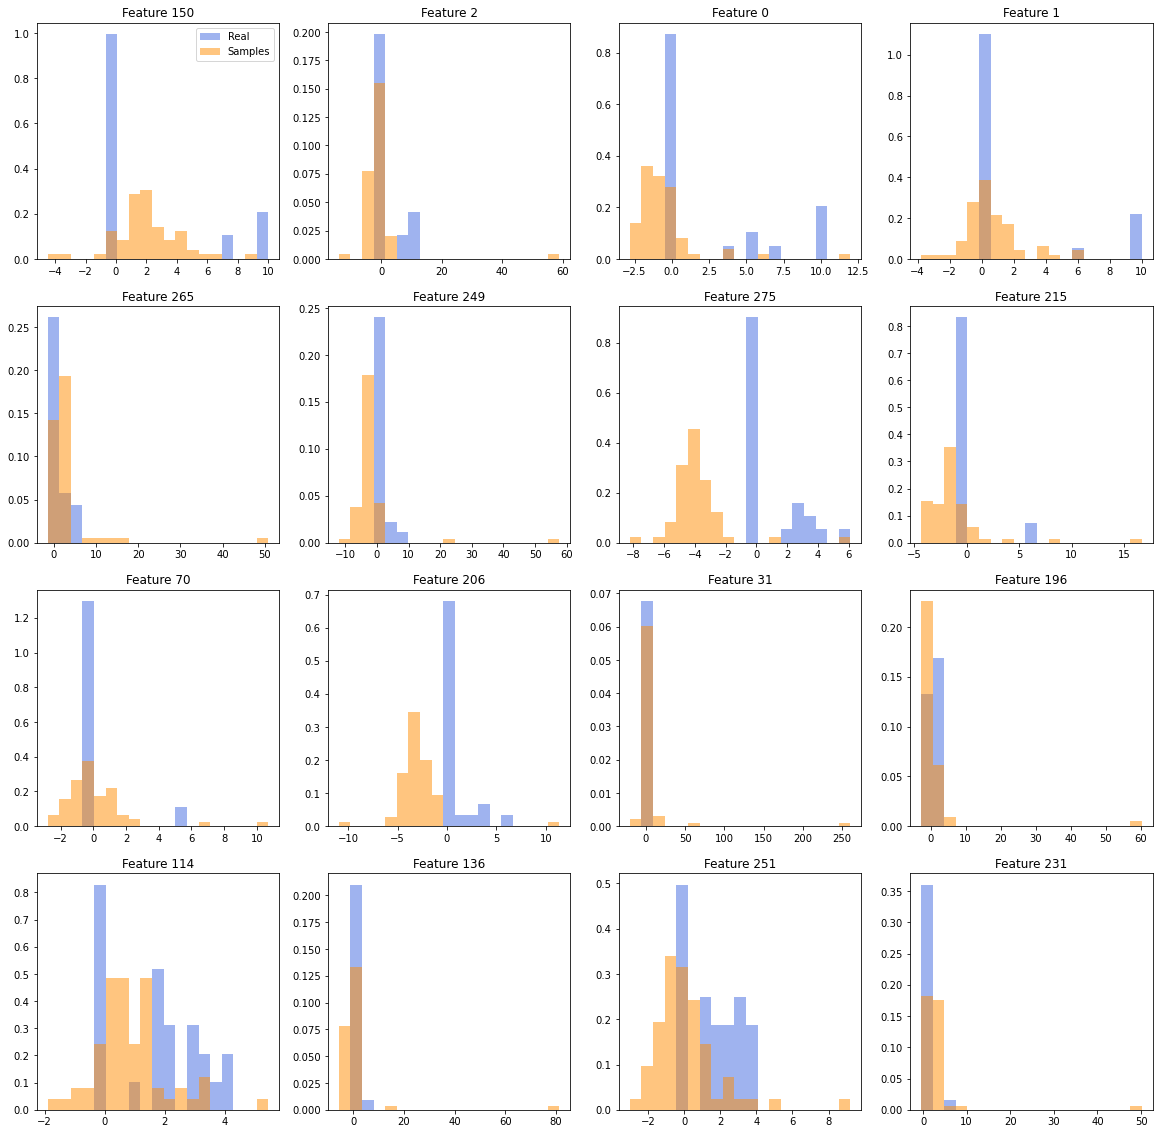

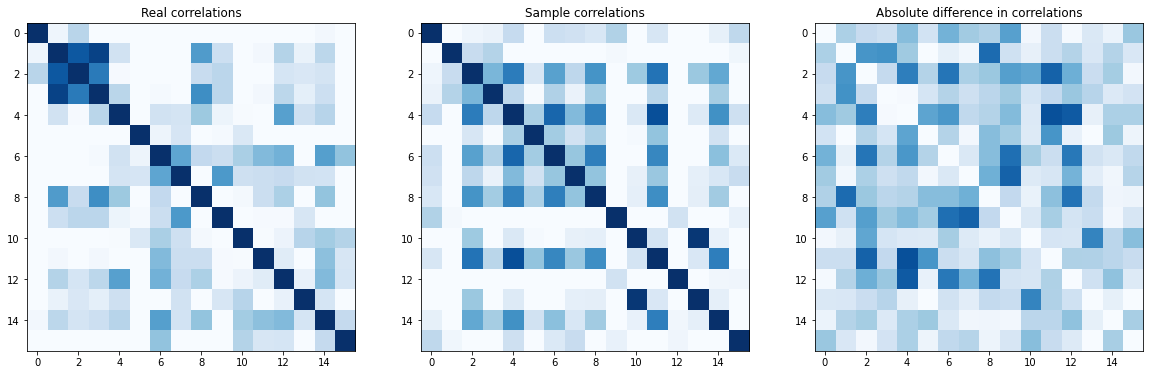

Class 11


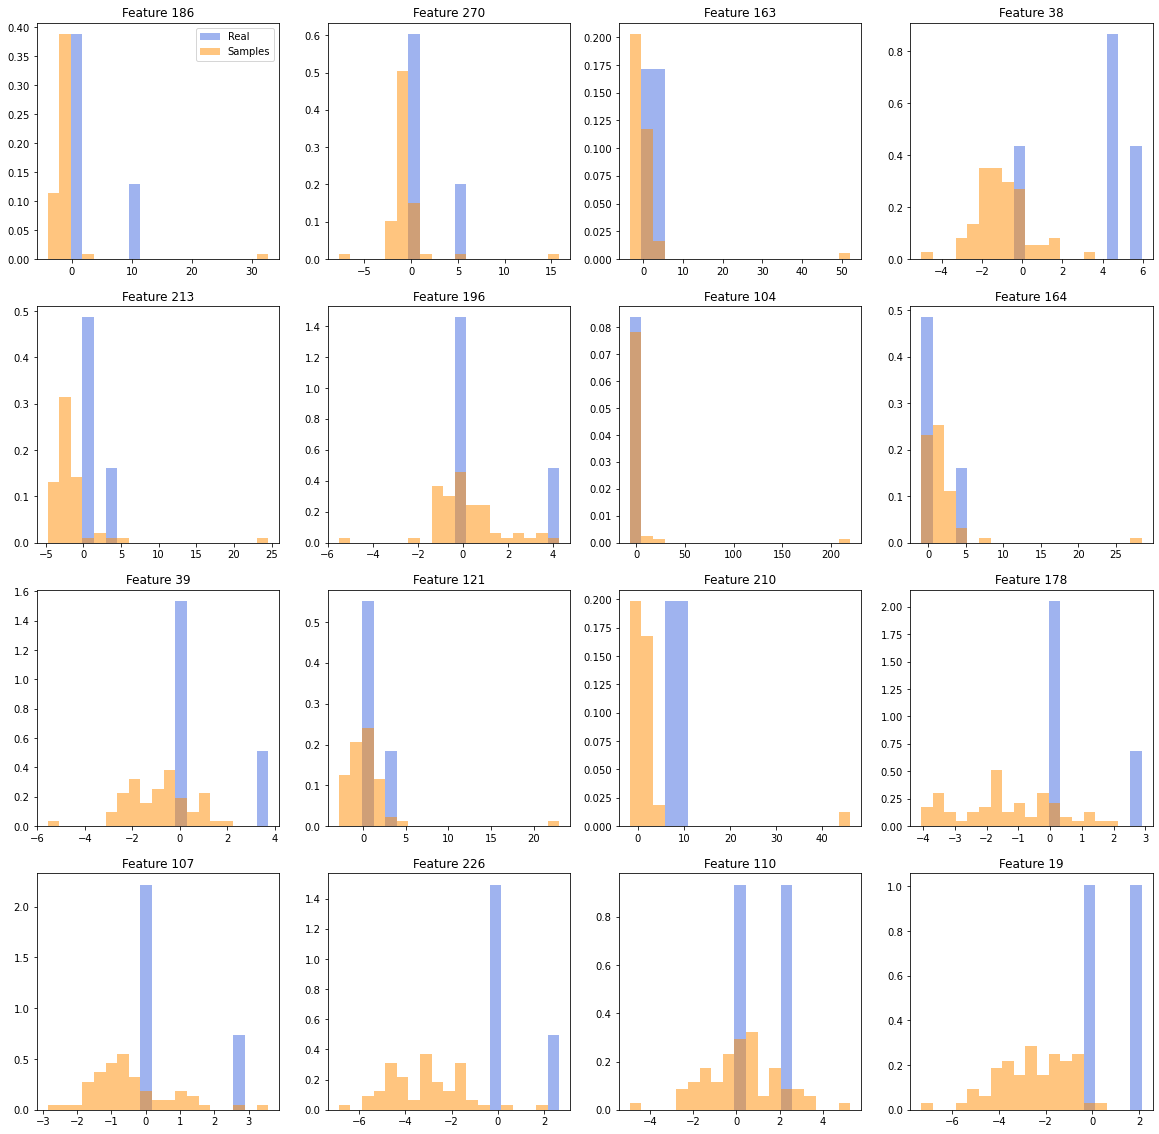

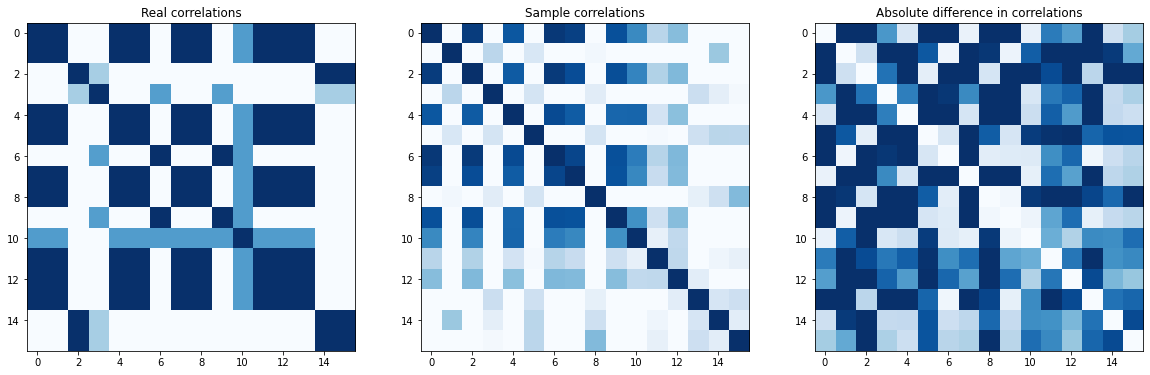

Class 12


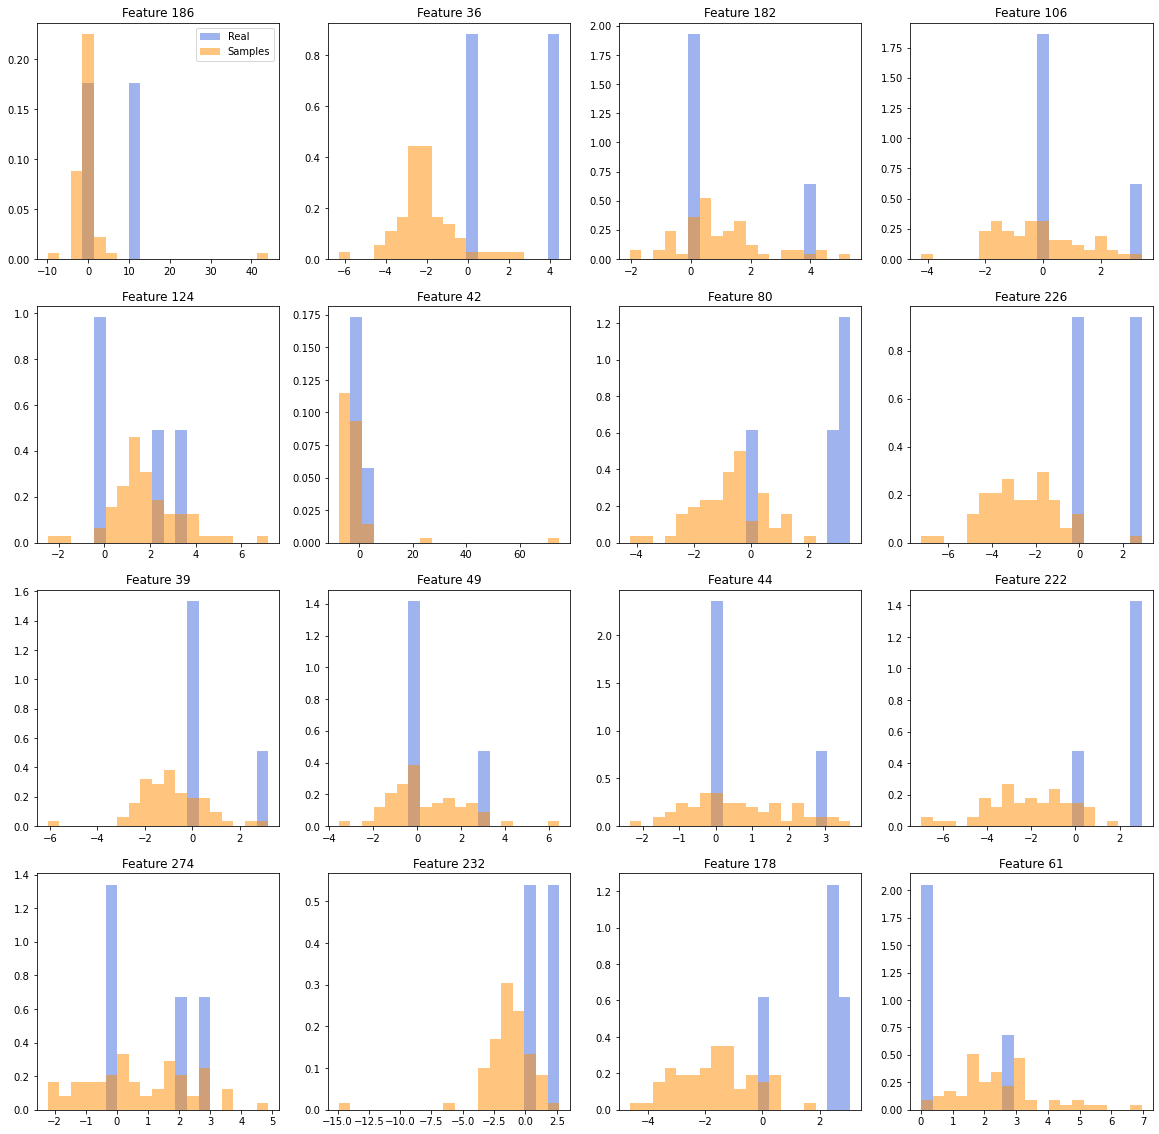

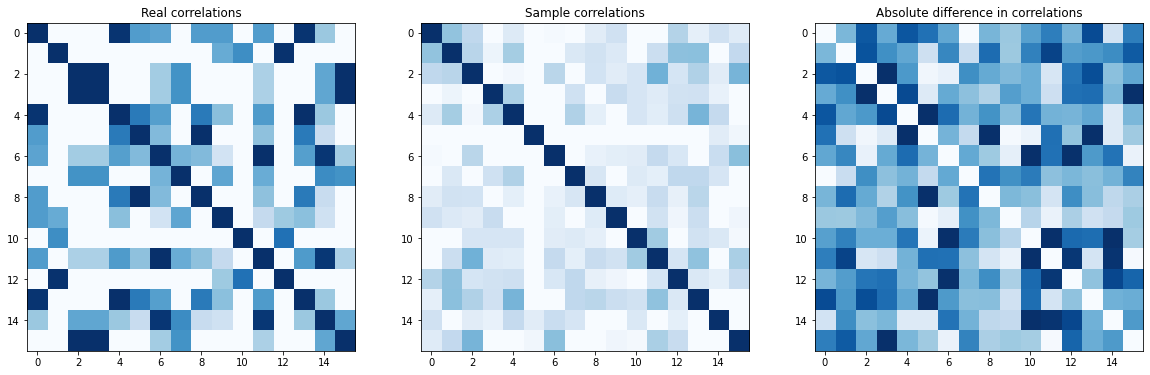

Class 13


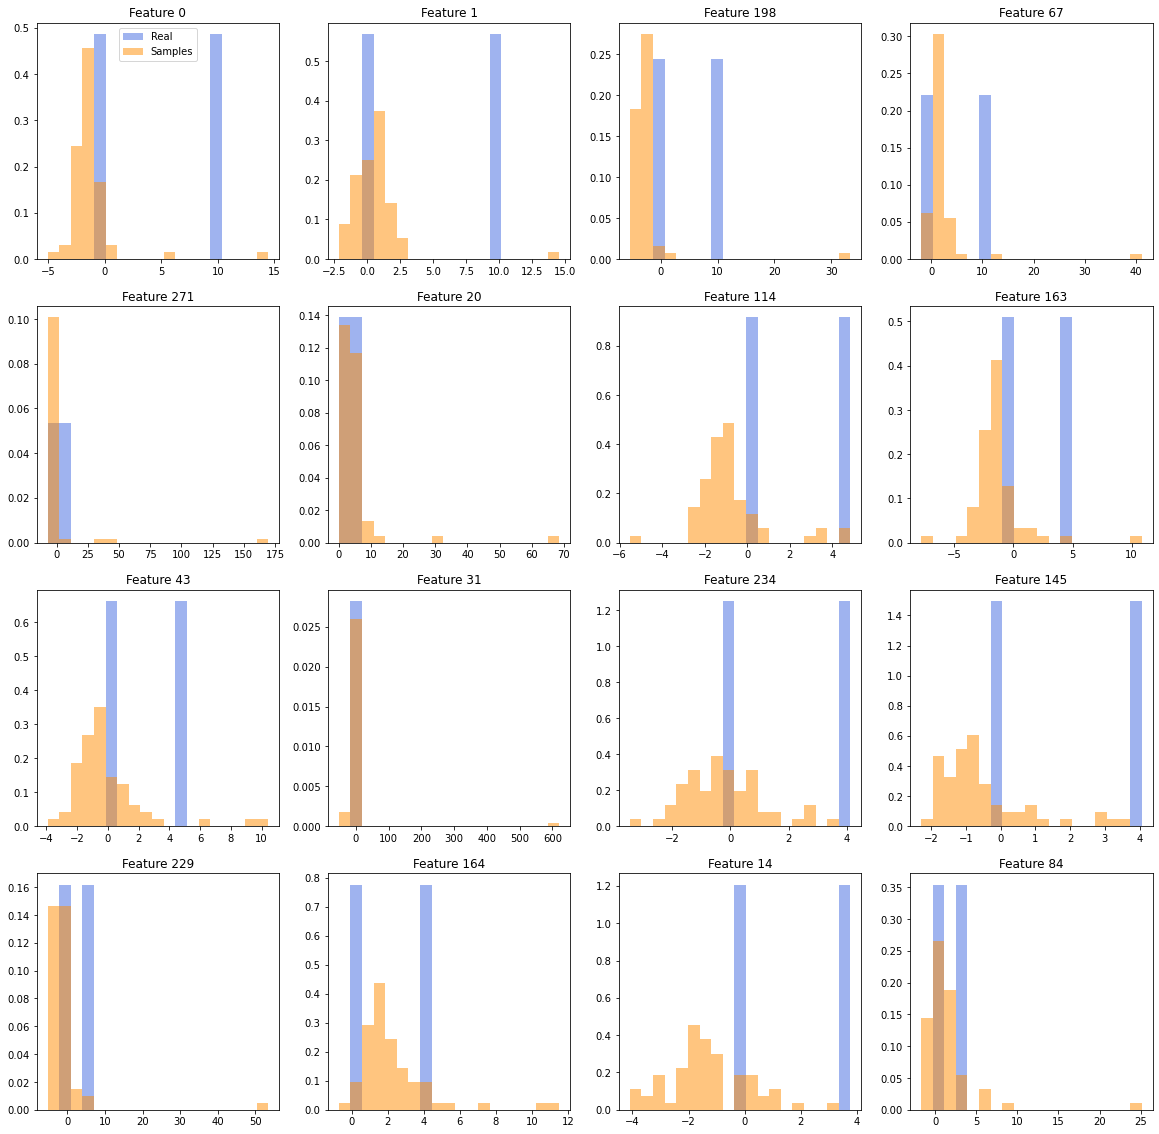

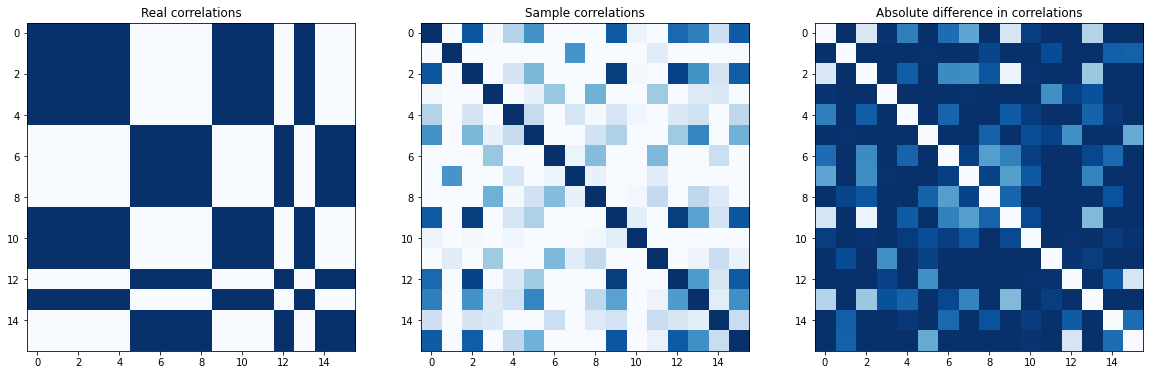

Class 14


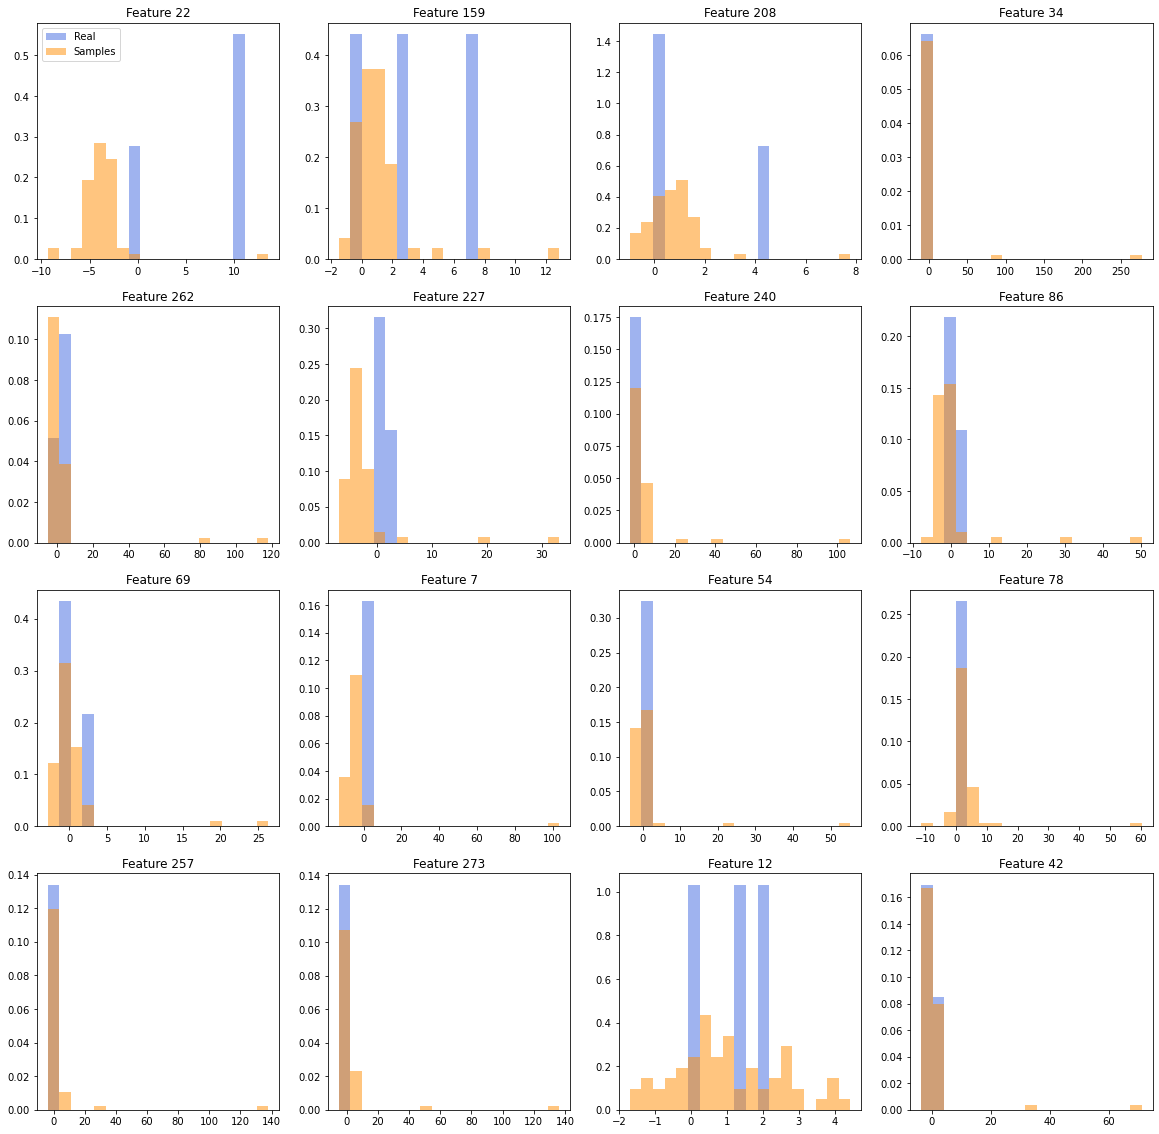

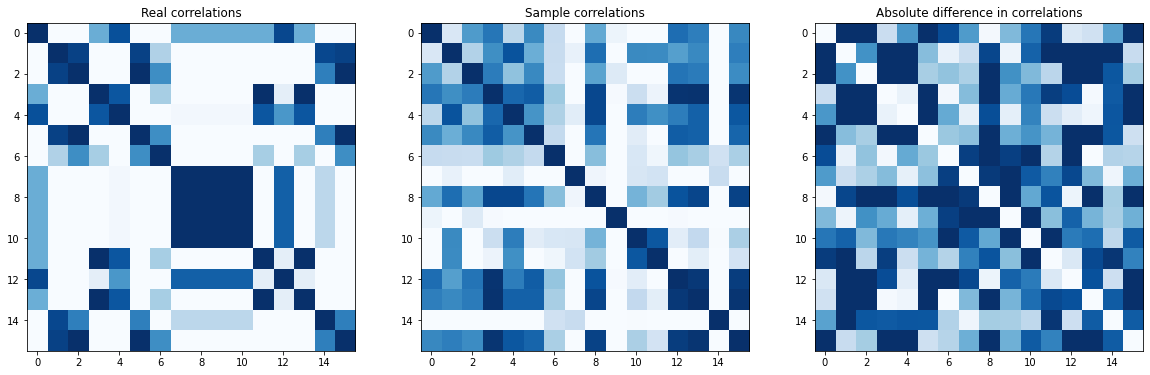

In [14]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(x.cpu().numpy())
    targets.append(y.cpu().numpy())
data = np.concatenate(data)
targets = np.concatenate(targets)

for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = data[targets == class_to_sample]
    sample = samples[class_to_sample]
    
    # Decide which features to plot
    num_features = min(input_shape[0], 16)
    feature_inds = np.flip(np.argsort(np.std(real, axis=0)))[:num_features]
    # feature_inds = np.random.choice(input_shape[0], size=num_features, replace=False)
    
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    # Plot feature values
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, f_i]
        sample_vals = sample[:, f_i]
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    plt.show()

    # Compute and plot correlations
    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i, f_i in enumerate(feature_inds):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            f_j = feature_inds[j]
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, f_i], real[:, f_j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, f_i], sample[:, f_j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

In [ ]:
# # Plot the distribution of features by class
# num_features = input_shape[0]
# num_cols = 4
# num_rows = int(np.ceil(num_features / num_cols))
# num_bins = 20
# fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))

# for i in range(num_features):
#     r, c = i // num_cols, i % num_cols
#     data_to_plot = {}
#     for class_to_sample in classes:
#         data_to_plot[class_to_sample] = data[targets == class_to_sample][:, i]
#     all_vals = np.concatenate(list(data_to_plot.values()))
#     bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
#     for class_to_sample in classes:
#         ax[r][c].hist(
#             data_to_plot[class_to_sample], bins=bins, label=class_to_letter[class_to_sample],
#             density=True, alpha=0.5
#         )
#     ax[r][c].set_title("Feature %d" % (i + 1))
# ax[0][0].legend()
# plt.show()

**Diffusing from one class to another**

In [ ]:
# branch_time = 0.35
# c1, c2 = "V", "Y"

# num_features = input_shape[0]

# orig_c1 = torch.stack([
#     dataset[i][0].to(DEVICE) for i in 
#     np.random.choice(np.where(dataset.targets == letter_to_class[c1])[0], size=512, replace=False)
# ])
# orig_c2 = torch.stack([
#     dataset[i][0].to(DEVICE) for i in 
#     np.random.choice(np.where(dataset.targets == letter_to_class[c2])[0], size=512, replace=False)
# ])

# time_steps = 10
# all_t = np.linspace(0, branch_time, time_steps)
# forward_c1_to_c2 = np.empty((len(all_t),) + orig_c1.shape)
# backward_c1_to_c2 = np.empty((len(all_t) - 1,) + orig_c1.shape)
# forward_c2_to_c1 = np.empty((len(all_t),) + orig_c2.shape)
# backward_c2_to_c1 = np.empty((len(all_t) - 1,) + orig_c2.shape)
# for t_i, t in enumerate(all_t):
#     forward_c1_to_c2[t_i] = sde.forward(
#         orig_c1, torch.ones(len(orig_c1)).to(DEVICE) * t
#     )[0].cpu().numpy()
#     forward_c2_to_c1[t_i] = sde.forward(
#         orig_c2, torch.ones(len(orig_c2)).to(DEVICE) * t
#     )[0].cpu().numpy()

# all_t_flip = np.flip(all_t)
# last_c1_to_c2 = torch.tensor(forward_c1_to_c2[-1]).to(DEVICE).float()
# last_c2_to_c1 = torch.tensor(forward_c2_to_c1[-1]).to(DEVICE).float()
# for t_i in range(len(all_t_flip) - 1):
#     last_c1_to_c2 = generate.generate_continuous_branched_samples(
#         model, sde, letter_to_class[c2], class_time_to_branch_tensor, sampler="pc",
#         t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
#         num_samples=orig_c1.shape[0], initial_samples=last_c1_to_c2,
#         num_steps=50
#     )
#     backward_c1_to_c2[t_i] = last_c1_to_c2.cpu().numpy()
    
#     last_c2_to_c1 = generate.generate_continuous_branched_samples(
#         model, sde, letter_to_class[c1], class_time_to_branch_tensor, sampler="pc",
#         t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
#         num_samples=orig_c2.shape[0], initial_samples=last_c2_to_c1,
#         num_steps=50
#     )
#     backward_c2_to_c1[t_i] = last_c2_to_c1.cpu().numpy()
    
# # Compute correlation of features before and after transmutation
# c1_to_c2_corrs, c2_to_c1_corrs = np.empty(num_features), np.empty(num_features)
# for i in range(num_features):
#     c1_to_c2_corrs[i] = scipy.stats.pearsonr(
#         forward_c1_to_c2[0][:, i], backward_c1_to_c2[-1][:, i]
#     )[0]
#     c2_to_c1_corrs[i] = scipy.stats.pearsonr(
#         forward_c2_to_c1[0][:, i], backward_c2_to_c1[-1][:, i]
#     )[0]
    
# # Plot distribution trajectory in transmutation
# fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))
# forward_cmap = plt.get_cmap("Reds_r")
# backward_cmap = plt.get_cmap("Blues")
# for t_i in range(len(all_t)):
#     ax[0].hist(
#         np.ravel(forward_c1_to_c2[t_i]), bins=60, histtype="step", color=forward_cmap(t_i / len(all_t)),
#         alpha=0.5, density=True
#     )
#     ax[1].hist(
#         np.ravel(forward_c2_to_c1[t_i]), bins=60, histtype="step", color=forward_cmap(t_i / len(all_t)),
#         alpha=0.5, density=True
#     )
# for t_i, t in enumerate(all_t_flip[1:]):
#     ax[0].hist(
#         np.ravel(backward_c1_to_c2[t_i]), bins=60, histtype="step", color=backward_cmap(t_i / len(all_t)),
#         alpha=0.5, density=True
#     )
#     ax[1].hist(
#         np.ravel(backward_c2_to_c1[t_i]), bins=60, histtype="step", color=backward_cmap(t_i / len(all_t)),
#         alpha=0.5, density=True
#     )
# ax[0].set_title("%s to %s" % (c1, c2))
# ax[1].set_title("%s to %s" % (c2, c1))
# ax[1].set_xlabel("x")
# ax[0].set_ylabel("p(x)")
# ax[1].set_ylabel("p(x)")
# ax[0].set_ylim((0, 3))
# plt.show()

# # Plot correlation of features before and after transmutation
# num_features = input_shape[0]
# num_cols = 4
# num_rows = int(np.ceil(num_features / num_cols))
# for class_1, class_2, forwards, backwards in [
#     (c1, c2, forward_c1_to_c2[0], backward_c1_to_c2[-1]),
#     (c2, c1, forward_c2_to_c1[0], backward_c2_to_c1[-1])
# ]:
#     fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
#     for i in range(num_features):
#         r, c = i // num_cols, i % num_cols
#         x, y = forwards[:, i], backwards[:, i]
#         corr = scipy.stats.pearsonr(x, y)[0]
#         ax[r][c].scatter(x, y, alpha=0.5)
#         ax[r][c].text(
#             0.01, 0.99, "%.4f" % corr,
#             ha="left", va="top", transform=ax[r][c].transAxes
#         )
#         ax[r][c].set_xlabel("Before forward diffusion")
#         ax[r][c].set_ylabel("After backward diffusion")
#         ax[r][c].set_title("Feature %d" % (i + 1))
#     fig.suptitle("%s to %s" % (class_1, class_2))
#     plt.show()